In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import datetime
import seaborn as sns
import missingno as msno
import firebase_admin
from firebase_admin import credentials, db
from datetime import datetime  # Untuk konversi timestamp ke human-readable
sns.set_theme(style="whitegrid")
%matplotlib inline 

In [2]:
# Konfigurasi database sumber
source_cred = credentials.Certificate("D:/staklimjerukagung-firebase-adminsdk-kcfma-e091165a9b.json")
firebase_admin.initialize_app(source_cred, {
    'databaseURL': 'https://staklimjerukagung-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

In [107]:
# Input readable date
start_readable_date = "01-11-2025 00:00:00"  # Format: DD-MM-YYYY HH:MM:SS
end_readable_date = "30-11-2025 23:59:59"  # Format: DD-MM-YYYY HH:MM:SS

# Convert readable date to Unix timestamp
start_timestamp = int(datetime.strptime(start_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(start_timestamp) # Convert to string and print
end_timestamp = int(datetime.strptime(end_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(end_timestamp) # Convert to string and print


1761930000
1764521999


In [108]:
def fetch_weather_data(station_id, start_ts, end_ts):
    """
    Mengambil data cuaca dari Firebase Realtime Database untuk stasiun dan rentang waktu tertentu.

    Args:
        station_id (str): ID stasiun cuaca (contoh: 'id-03', 'id-04').
        start_ts (int): Timestamp awal (epoch time).
        end_ts (int): Timestamp akhir (epoch time).

    Returns:
        dict: Hasil data dari Firebase, atau None jika tidak ada data.
    """
    try:
        # Membuat path referensi secara dinamis berdasarkan station_id
        ref_path = f'/auto_weather_stat/{station_id}/data'
        ref_data = db.reference(ref_path)

        # Membuat query dengan rentang waktu
        query_data = ref_data.order_by_key().start_at(str(start_ts)).end_at(str(end_ts))

        # Mengambil dan mengembalikan hasil
        results = query_data.get()
        print(f"Data untuk stasiun {station_id} berhasil diambil.")
        return results
    except Exception as e:
        print(f"Terjadi error saat mengambil data untuk {station_id}: {e}")
        return None

# 2. Siapkan daftar ID stasiun yang ingin diambil datanya
station_ids = ['id-03', 'id-05'] # Mudah untuk menambah stasiun baru

# 3. Gunakan loop untuk mengambil data semua stasiun dan simpan hasilnya
all_weather_data = {}
for station in station_ids:
    # Panggil fungsi untuk setiap stasiun
    data = fetch_weather_data(station, start_timestamp, end_timestamp)
    if data:
        all_weather_data[station] = data

Data untuk stasiun id-03 berhasil diambil.
Data untuk stasiun id-05 berhasil diambil.


In [109]:
def create_weather_dataframe(data_dict, source_name):
    """
    Mengubah dictionary data cuaca menjadi DataFrame Pandas.

    Args:
        data_dict (dict): Dictionary berisi data cuaca yang diambil dari Firebase.
        source_name (str): Nama atau ID sumber data untuk keperluan logging/print.

    Returns:
        pandas.DataFrame: DataFrame yang sudah diformat, atau None jika input kosong.
    """
    # Periksa apakah ada data untuk diproses
    if not data_dict:
        print(f"Tidak ada data dari sumber '{source_name}' untuk diproses.")
        return None

    try:
        # Mengubah data dari dictionary menjadi DataFrame
        # 'orient="index"' menjadikan key dari dictionary sebagai baris awal
        df = pd.DataFrame.from_dict(data_dict, orient='index')

        # Memastikan kolom 'timestamp' ada.
        # Jika 'timestamp' bukan salah satu kolom, berarti ia adalah indeks.
        if 'timestamp' not in df.columns:
            df.index.name = 'timestamp'  # Beri nama pada indeks
            df.reset_index(inplace=True) # Pindahkan indeks menjadi kolom biasa

        print(f"DataFrame untuk sumber '{source_name}' berhasil dibuat.")
        return df
        
    except Exception as e:
        print(f"Gagal membuat DataFrame untuk '{source_name}': {e}")
        return None


# 2. Siapkan dictionary kosong untuk menampung DataFrame yang akan kita buat
weather_dataframes = {}

# 3. Loop melalui setiap item di all_weather_data
#    Gunakan .items() untuk mendapatkan key (nama stasiun) dan value (datanya)
for station_id, raw_data in all_weather_data.items():
    
    # Panggil fungsi baru kita untuk mengubah data mentah menjadi DataFrame
    df = create_weather_dataframe(raw_data, station_id)
    
    # Jika DataFrame berhasil dibuat, simpan ke dalam dictionary kita
    if df is not None:
        weather_dataframes[station_id] = df

# 4. Sekarang semua DataFrame Anda tersimpan rapi di satu tempat
print("\n--- Verifikasi Hasil ---")

DataFrame untuk sumber 'id-03' berhasil dibuat.
DataFrame untuk sumber 'id-05' berhasil dibuat.

--- Verifikasi Hasil ---


In [110]:
def save_weather_data_to_csv(data_dict, output_folder='analisis'):
    """
    Menyimpan setiap DataFrame dalam dictionary ke file CSV terpisah.

    Args:
        data_dict (dict): Dictionary berisi {station_id: DataFrame}.
        output_folder (str): Nama folder untuk menyimpan file CSV.
    """
    # Pastikan modul os terimport (biasanya sudah di cell paling atas, tapi untuk keamanan)
    import os

    # Buat folder jika belum ada
    if not os.path.exists(output_folder):
        try:
            os.makedirs(output_folder)
            print(f"Folder '{output_folder}' berhasil dibuat.")
        except OSError as e:
            print(f"Gagal membuat folder '{output_folder}': {e}")
            return

    print(f"\n--- Menyimpan Data ke Folder '{output_folder}' ---")

    for station_id, df in data_dict.items():
        try:
            # Buat nama file yang aman
            filename = f"meteo_data_{station_id}.csv"
            file_path = os.path.join(output_folder, filename)

            # Simpan ke CSV
            # index=False karena timestamp biasanya sudah di-reset menjadi kolom di langkah sebelumnya
            df.to_csv(file_path, index=False)
            print(f"Berhasil menyimpan: {filename}")
        except Exception as e:
            print(f"Gagal menyimpan data untuk {station_id}: {e}")

# Panggil fungsi untuk menyimpan data
save_weather_data_to_csv(weather_dataframes)


--- Menyimpan Data ke Folder 'analisis' ---
Berhasil menyimpan: meteo_data_id-03.csv
Berhasil menyimpan: meteo_data_id-05.csv


In [111]:
def load_weather_data_from_csv(input_folder='analisis'):
    """
    Membaca kembali file CSV dari folder ke dalam dictionary DataFrame.

    Args:
        input_folder (str): Nama folder tempat file CSV disimpan.

    Returns:
        dict: Dictionary berisi {station_id: DataFrame}.
    """
    import os
    import pandas as pd

    loaded_data = {}

    # Cek apakah folder ada
    if not os.path.exists(input_folder):
        print(f"Folder '{input_folder}' tidak ditemukan.")
        return loaded_data

    print(f"\n--- Membaca Data dari Folder '{input_folder}' ---")

    try:
        # Loop semua file di folder
        for filename in os.listdir(input_folder):
            if filename.endswith(".csv") and filename.startswith("meteo_data_"):
                # Ekstrak station_id dari nama file (meteo_data_id-03.csv -> id-03)
                station_id = filename.replace("meteo_data_", "").replace(".csv", "")
                
                file_path = os.path.join(input_folder, filename)
                
                # Baca CSV ke DataFrame
                df = pd.read_csv(file_path)
                
                # Simpan ke dictionary
                loaded_data[station_id] = df
                print(f"Berhasil memuat: {station_id} ({len(df)} baris)")
                
        return loaded_data

    except Exception as e:
        print(f"Terjadi kesalahan saat membaca data: {e}")
        return {}


# Uncomment baris di bawah ini jika ingin me-load data dari CSV menggantikan data dari API
weather_dataframes = load_weather_data_from_csv()


--- Membaca Data dari Folder 'analisis' ---
Berhasil memuat: id-03 (39195 baris)
Berhasil memuat: id-05 (38591 baris)


In [112]:
if 'id-03' in weather_dataframes:
    print("\nMenampilkan data dari DataFrame 'id-03':")
    print(weather_dataframes['id-03'].tail(10))
if 'id-04' in weather_dataframes:
    print("\nMenampilkan data dari DataFrame 'id-04':")
    print(weather_dataframes['id-04'].tail(10))
if 'id-05' in weather_dataframes:
    print("\nMenampilkan data dari DataFrame 'id-05':")
    print(weather_dataframes['id-05'].tail(10))


Menampilkan data dari DataFrame 'id-03':
            dew  humidity  pressure  temperature   timestamp  volt  rainfall  \
39185  26.19360     68.70   1008.99        32.70  1764307500  4.14       NaN   
39186  26.03238     68.51   1008.94        32.58  1764307560  4.14       NaN   
39187  25.94134     68.45   1008.93        32.50  1764307620  4.14       NaN   
39188  25.91517     68.19   1008.89        32.54  1764307681  4.14       NaN   
39189  25.98158     68.42   1008.94        32.55  1764307741  4.14       NaN   
39190  26.07141     68.94   1008.84        32.51  1764307801  4.14       NaN   
39191  26.01005     69.04   1008.80        32.42  1764307861  4.14       NaN   
39192  26.26019     69.95   1008.80        32.45  1764307921  4.14       NaN   
39193  26.32019     70.04   1008.79        32.49  1764307982  4.14       NaN   
39194  26.44488     70.20   1008.80        32.58  1764308041  4.14       NaN   

       rainrate  
39185       NaN  
39186       NaN  
39187       NaN  
39188

In [113]:
weather_dataframes['id-05'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38591 entries, 0 to 38590
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          38591 non-null  float64
 1   humidity     38591 non-null  float64
 2   pressure     38591 non-null  float64
 3   rainfall     38591 non-null  float64
 4   rainrate     38591 non-null  float64
 5   temperature  38591 non-null  float64
 6   timestamp    38591 non-null  int64  
 7   volt         38591 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 2.4 MB


In [114]:
def convert_timestamp_to_int(df, column_name='timestamp'):
    """
    Mengubah tipe data kolom tertentu dalam DataFrame menjadi integer.

    Args:
        df (pd.DataFrame): DataFrame yang akan dimodifikasi.
        column_name (str): Nama kolom yang akan diubah tipenya. Defaultnya adalah 'timestamp'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi, atau DataFrame asli jika kolom tidak ditemukan.
    """
    # Periksa apakah input adalah DataFrame yang valid dan memiliki kolom yang dimaksud
    if isinstance(df, pd.DataFrame) and column_name in df.columns:
        try:
            df[column_name] = df[column_name].astype(int)
            print(f"Kolom '{column_name}' berhasil diubah menjadi tipe integer.")
        except Exception as e:
            print(f"Gagal mengubah tipe data kolom '{column_name}': {e}")
    else:
        # Memberi tahu pengguna jika kolom tidak ada di DataFrame
        print(f"Peringatan: Kolom '{column_name}' tidak ditemukan dalam DataFrame.")
        
    return df



In [115]:
# Loop melalui setiap DataFrame dan terapkan fungsi konversi
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = convert_timestamp_to_int(weather_dataframes[station_id])

print("\n--- Memeriksa tipe data SETELAH konversi ---")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diubah menjadi tipe integer.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diubah menjadi tipe integer.

--- Memeriksa tipe data SETELAH konversi ---


In [116]:
def format_datetime_column(df, column_name='timestamp', target_tz='UTC'):
    """
    Mengonversi kolom timestamp (integer) ke datetime dengan zona waktu tertentu.

    Proses:
    1. Mengubah integer timestamp (detik) menjadi datetime dalam UTC.
    2. Mengonversi datetime dari UTC ke zona waktu target (default: 'Asia/Jakarta').

    Args:
        df (pd.DataFrame): DataFrame yang akan diproses.
        column_name (str): Nama kolom timestamp. Defaultnya 'timestamp'.
        target_tz (str): Zona waktu target. Defaultnya 'Asia/Jakarta'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi.
    """
    # Pastikan input adalah DataFrame dan kolomnya ada
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Konversi dari integer (epoch seconds) ke datetime UTC
        df[column_name] = pd.to_datetime(df[column_name], unit='s', utc=True)
        
        # Langkah 2: Konversi zona waktu dari UTC ke target_tz (WIB)
        df[column_name] = df[column_name].dt.tz_convert(target_tz)
        
        print(f"Kolom '{column_name}' berhasil diformat ke zona waktu {target_tz}.")
    except Exception as e:
        print(f"Gagal memformat kolom '{column_name}': {e}")
        
    return df

In [117]:
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = format_datetime_column(weather_dataframes[station_id])

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diformat ke zona waktu UTC.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diformat ke zona waktu UTC.


In [118]:
def add_time_features(df, column_name='timestamp'):
    """
    Menambahkan kolom-kolom berbasis waktu (jam, hari, bulan, dll.) ke DataFrame.

    Proses:
    1. Memastikan kolom waktu berformat datetime.
    2. Mengurutkan DataFrame berdasarkan kolom waktu tersebut.
    3. Mengekstrak dan menambahkan kolom 'hour', 'minute', 'day', 'week', 'month', dan 'year'.

    Args:
        df (pd.DataFrame): DataFrame input.
        column_name (str): Nama kolom datetime yang akan diproses.

    Returns:
        pd.DataFrame: DataFrame baru dengan kolom-kolom waktu tambahan.
    """
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Memastikan kolom 'timestamp' berformat datetime (sebagai pengaman)
        df[column_name] = pd.to_datetime(df[column_name])

        # Langkah 2: Mengurutkan data berdasarkan 'timestamp'
        df = df.sort_values(by=column_name)

        # Langkah 3: Menambahkan kolom-kolom waktu
        df['hour'] = df[column_name].dt.hour
        df['minute'] = df[column_name].dt.minute
        df['day'] = df[column_name].dt.day
        df['week'] = df[column_name].dt.isocalendar().week.astype(int) # .isocalendar() menghasilkan object kompleks
        df['month'] = df[column_name].dt.month
        df['year'] = df[column_name].dt.year
        
        print(f"Fitur waktu berhasil ditambahkan ke DataFrame.")
    except Exception as e:
        print(f"Gagal menambahkan fitur waktu: {e}")
        
    return df

In [119]:
for station_id in weather_dataframes:
    print(f"--- Memproses DataFrame untuk stasiun: {station_id} ---")
    weather_dataframes[station_id] = add_time_features(weather_dataframes[station_id])

print("\n" + "="*50 + "\n")

# Verifikasi hasil dari dictionary
print("Hasil akhir untuk 'id-05' dari dictionary:")
print(weather_dataframes['id-05'].tail(10))

--- Memproses DataFrame untuk stasiun: id-03 ---
Fitur waktu berhasil ditambahkan ke DataFrame.
--- Memproses DataFrame untuk stasiun: id-05 ---
Fitur waktu berhasil ditambahkan ke DataFrame.


Hasil akhir untuk 'id-05' dari dictionary:
            dew  humidity  pressure  rainfall  rainrate  temperature  \
38581  25.87756  68.76921   1009.43    1.6764       0.0     32.37011   
38582  26.03510  69.41199   1009.45    1.6764       0.0     32.37011   
38583  25.80861  68.29427   1009.39    1.6764       0.0     32.42085   
38584  26.31167  69.74197   1009.43    1.6764       0.0     32.57572   
38585  25.97839  68.29237   1009.30    1.6764       0.0     32.59975   
38586  26.37048  70.13107   1009.35    1.6764       0.0     32.53834   
38587  26.39326  69.82590   1009.34    1.6764       0.0     32.63981   
38588  26.89758  71.79622   1009.29    1.6764       0.0     32.67185   
38589  26.86709  71.16487   1009.27    1.6764       0.0     32.79736   
38590  26.73639  70.50492   1009.22    1.67

In [120]:
# Mengekstrak setiap DataFrame ke variabel terpisah
cuaca1 = weather_dataframes['id-03']
#cuaca2 = weather_dataframes['id-04']
cuaca3 = weather_dataframes['id-05']

In [121]:
cuaca3.tail(50)

dew  humidity  pressure  rainfall  rainrate  temperature  \
38541  26.22922  70.99702   1009.78    1.6764       0.0     32.17250   
38542  25.94767  70.24933   1009.77    1.6764       0.0     32.06569   
38543  26.41622  71.59975   1009.73    1.6764       0.0     32.21790   
38544  26.95963  73.52239   1009.77    1.6764       0.0     32.31403   
38545  26.60097  72.13191   1009.73    1.6764       0.0     32.27932   
38546  26.46144  71.85535   1009.73    1.6764       0.0     32.20187   
38547  26.23269  71.27932   1009.68    1.6764       0.0     32.10574   
38548  25.85039  70.47059   1009.71    1.6764       0.0     31.90814   
38549  25.79443  69.70000   1009.70    1.6764       0.0     32.04433   
38550  26.08000  70.98177   1009.69    1.6764       0.0     32.02029   
38551  26.24003  71.94690   1009.70    1.6764       0.0     31.94820   
38552  26.01433  71.11337   1009.68    1.6764       0.0     31.91882   
38553  26.59449  72.95590   1009.71    1.6764       0.0     32.07103   
38554  26.84015  73.79324   1009.71    1.6764       0.0     32.12444   
38555  26.68385  72.96544   1009.67    1.6764       0.0     32.16182   
38556  26.73575  73.03410   1009.73    1.6764       0.0     32.19920   
38557  26.50035  71.67414   1009.69    1.6764       0.0     32.28733   
38558  26.14420  70.30274   1009.64    1.6764       0.0     32.25796   
38559  26.25805  70.60601   1009.65    1.6764       0.0     32.30068   
38560  26.44943  71.08476   1009.70    1.6764       0.0     32.38079   
38561  26.74117  71.98886   1009.66    1.6764       0.0     32.46090   
38562  25.86225  68.89319   1009.60    1.6764       0.0     32.32204   
38563  26.28637  70.28939   1009.64    1.6764       0.0     32.41016   
38564  26.43555  71.01610   1009.63    1.6764       0.0     32.38346   
38565  26.50650  70.98177   1009.64    1.6764       0.0     32.46624   
38566  26.54078  70.94362   1009.60    1.6764       0.0     32.51163   
38567  26.26254  70.04333   1009.60    1.6764       0.0     32.44755   
38568  26.38720  70.09483   1009.58    1.6764       0.0     32.56504   
38569  26.69223  70.84062   1009.58    1.6764       0.0     32.69588   
38570  26.49620  70.65179   1009.59    1.6764       0.0     32.53834   
38571  26.47166  70.26460   1009.59    1.6764       0.0     32.61044   
38572  26.02379  69.00191   1009.55    1.6764       0.0     32.46357   
38573  26.11017  69.03242   1009.54    1.6764       0.0     32.54635   
38574  25.93827  68.15121   1009.53    1.6764       0.0     32.59441   
38575  26.26755  69.42535   1009.52    1.6764       0.0     32.61044   
38576  26.27534  69.81255   1009.48    1.6764       0.0     32.51965   
38577  26.09205  69.28039   1009.53    1.6764       0.0     32.46357   
38578  26.05422  69.53216   1009.48    1.6764       0.0     32.35943   
38579  26.10160  69.30900   1009.47    1.6764       0.0     32.46624   
38580  25.83025  68.41253   1009.47    1.6764       0.0     32.41283   
38581  25.87756  68.76921   1009.43    1.6764       0.0     32.37011   
38582  26.03510  69.41199   1009.45    1.6764       0.0     32.37011   
38583  25.80861  68.29427   1009.39    1.6764       0.0     32.42085   
38584  26.31167  69.74197   1009.43    1.6764       0.0     32.57572   
38585  25.97839  68.29237   1009.30    1.6764       0.0     32.59975   
38586  26.37048  70.13107   1009.35    1.6764       0.0     32.53834   
38587  26.39326  69.82590   1009.34    1.6764       0.0     32.63981   
38588  26.89758  71.79622   1009.29    1.6764       0.0     32.67185   
38589  26.86709  71.16487   1009.27    1.6764       0.0     32.79736   
38590  26.73639  70.50492   1009.22    1.6764       0.0     32.82674   

                      timestamp     volt  hour  minute  day  week  month  year  
38541 2025-11-28 04:45:33+00:00  3.93875     4      45   28    48     11  2025  
38542 2025-11-28 04:46:33+00:00  3.93625     4      46   28    48     11  2025  
38543 2025-11-28 04:47:33+00:00  3.94250     4      47   28    48     11  2025  
38544 2025-11-2

=== Informasi Missing Values dalam cuaca3 ===

dew                0
humidity           0
pressure           0
temperature        0
timestamp          0
volt               0
rainfall       39194
rainrate       39194
hour               0
minute             0
day                0
week               0
month              0
year               0
dtype: int64


=== Persentase Missing Values ===

dew             0.000000
humidity        0.000000
pressure        0.000000
temperature     0.000000
timestamp       0.000000
volt            0.000000
rainfall       99.997449
rainrate       99.997449
hour            0.000000
minute          0.000000
day             0.000000
week            0.000000
month           0.000000
year            0.000000
dtype: float64


=== Visualisasi Missing Values ===


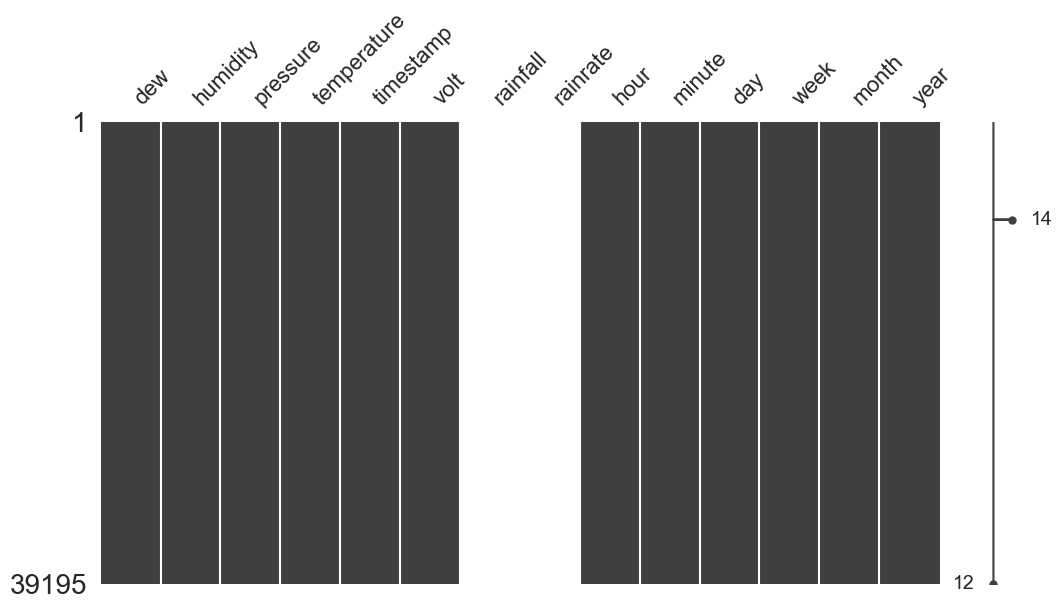


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 39194

Contoh baris dengan null:
        dew  humidity  pressure  temperature                 timestamp  volt  \
0  24.54409     98.13   1011.90        24.86 2025-10-31 17:00:00+00:00  4.10   
1  24.51076     98.11   1011.88        24.83 2025-10-31 17:01:00+00:00  4.10   
2  24.54409     98.13   1011.88        24.86 2025-10-31 17:02:00+00:00  4.10   
3  24.55577     98.14   1011.87        24.87 2025-10-31 17:03:00+00:00  4.10   
4  24.54750     98.15   1011.84        24.86 2025-10-31 17:04:01+00:00  4.09   
5  24.54750     98.15   1011.85        24.86 2025-10-31 17:05:01+00:00  4.09   
6  24.56404     98.13   1011.80        24.88 2025-10-31 17:06:01+00:00  4.09   
7  24.54093     98.17   1011.79        24.85 2025-10-31 17:07:01+00:00  4.09   
8  24.53923     98.16   1011.78        24.85 2025-10-31 17:08:01+00:00  4.09   
9  24.54750     98.15   1011.82        24.86 2025-10-31 17:09:01+00:00  4.09   

   rainfall  rainrate  hour

In [122]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca1.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca1.isnull().sum() / len(cuaca1)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca1, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca1[cuaca1.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

=== Informasi Missing Values dalam cuaca3 ===

dew            0
humidity       0
pressure       0
rainfall       0
rainrate       0
temperature    0
timestamp      0
volt           0
hour           0
minute         0
day            0
week           0
month          0
year           0
dtype: int64


=== Persentase Missing Values ===

dew            0.0
humidity       0.0
pressure       0.0
rainfall       0.0
rainrate       0.0
temperature    0.0
timestamp      0.0
volt           0.0
hour           0.0
minute         0.0
day            0.0
week           0.0
month          0.0
year           0.0
dtype: float64


=== Visualisasi Missing Values ===


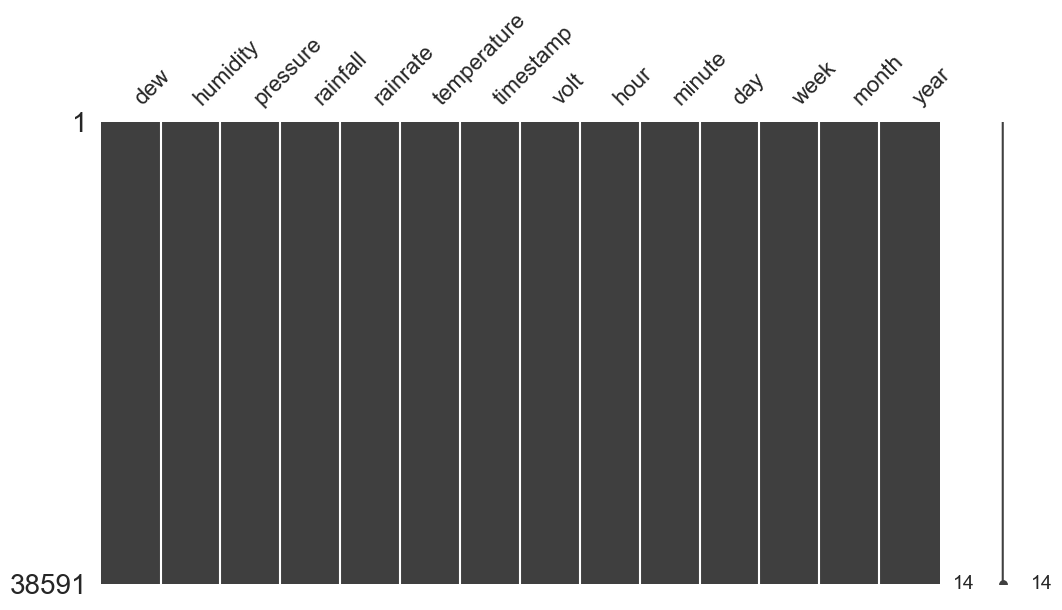


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 0

Contoh baris dengan null:
Empty DataFrame
Columns: [dew, humidity, pressure, rainfall, rainrate, temperature, timestamp, volt, hour, minute, day, week, month, year]
Index: []


In [123]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca3.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca3.isnull().sum() / len(cuaca3)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca3, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca3[cuaca3.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

In [124]:
cuaca3['timestamp'] = pd.to_datetime(cuaca3['timestamp'])
cuaca3 = cuaca3.set_index('timestamp')

In [125]:
cuaca3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38591 entries, 2025-10-31 17:00:53+00:00 to 2025-11-28 05:34:33+00:00
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          38591 non-null  float64
 1   humidity     38591 non-null  float64
 2   pressure     38591 non-null  float64
 3   rainfall     38591 non-null  float64
 4   rainrate     38591 non-null  float64
 5   temperature  38591 non-null  float64
 6   volt         38591 non-null  float64
 7   hour         38591 non-null  int32  
 8   minute       38591 non-null  int32  
 9   day          38591 non-null  int32  
 10  week         38591 non-null  int64  
 11  month        38591 non-null  int32  
 12  year         38591 non-null  int32  
dtypes: float64(7), int32(5), int64(1)
memory usage: 3.4 MB


In [126]:
def plot_station_trends(data_dict, column_to_plot, freq='d'):
    """
    Membuat plot tren perbandingan untuk sebuah kolom dari beberapa stasiun cuaca.

    Args:
        data_dict (dict): Dictionary yang berisi {station_id: DataFrame}.
        column_to_plot (str): Nama kolom yang akan di-plot (misal: 'temperature').
        freq (str): Frekuensi untuk pengelompokan data.
                    'd' untuk harian (daily).
                    'h' untuk per jam (hourly).
    """
    # Menentukan label berdasarkan frekuensi
    freq_labels = {
        'd': {'label': 'Harian', 'xlabel': 'Tanggal'},
        'h': {'label': 'Per Jam', 'xlabel': 'Waktu (Jam)'},
        'min': {'label': 'Per Menit', 'xlabel': 'Waktu (Menit)'}
    }
    
    # Pilih label yang sesuai, default ke 'Harian' jika freq tidak dikenali
    selected_freq = freq_labels.get(freq, freq_labels['d'])
    
    # Membuat figure dan axes untuk plot
    plt.figure(figsize=(15, 7))

    # Loop melalui setiap stasiun dalam dictionary
    for station_id, df in data_dict.items():
        if column_to_plot not in df.columns:
            print(f"Peringatan: Kolom '{column_to_plot}' tidak ada di stasiun {station_id}. Dilewati.")
            continue

        temp_df = df.copy()
        
        # Mengelompokkan data berdasarkan frekuensi (harian atau per jam)
        time_group_col = f'time_group_{freq}'
        temp_df[time_group_col] = temp_df['timestamp'].dt.floor(freq)
        trend_data = temp_df.groupby(time_group_col)[column_to_plot].mean().reset_index()

        # Plot data untuk stasiun saat ini
        plt.plot(trend_data[time_group_col], trend_data[column_to_plot], label=station_id, alpha=0.8)

    # Menambahkan detail pada plot
    plt.xlabel(selected_freq['xlabel'])
    plt.ylabel(f"Rata-rata {column_to_plot.capitalize()}")
    plt.title(f"Perbandingan Rata-rata {selected_freq['label']} {column_to_plot.capitalize()} antar Stasiun")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Menampilkan plot
    plt.show()

In [127]:
# --- 1. PERSIAPAN DATA ---
df = cuaca3.copy()

# Ganti 'timestamp' dengan nama kolom waktu yang sesuai di cuaca3 jika beda
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').sort_index()

# HANDLING TIMEZONE (TETAP UTC)
# Jika data masih polos (naive), kita tempel label UTC.
# Jika sudah ada labelnya, biarkan saja (biasanya raw data itu UTC).
if df.index.tz is None:
    df = df.tz_localize('UTC') 

# [HAPUS/KOMENTARI BARIS INI AGAR TETAP UTC]
# df = df.tz_convert('Asia/Jakarta') 

# --- 2. PROSES HUJAN (WAJIB ISI!) ---
# Logika tetap sama: ffill -> diff -> clip
rain_series = df['rainrate'].resample('1min').ffill()
rain_per_minute = rain_series.diff().fillna(0).clip(lower=0)

# --- 3. PROSES VARIABEL LAIN (BIARKAN KOSONG/JUJUR) ---
# Resample rata-rata per menit
other_vars = df[['temperature', 'humidity', 'pressure', 'dew', 'volt']].resample('1min').mean()

# --- 4. GABUNGKAN KEMBALI ---
data_menit_utc = other_vars.copy()
data_menit_utc['rain_mm'] = rain_per_minute

# Tampilkan Hasil
print("--- Data Menit (Zona Waktu: UTC) ---")
print(data_menit_utc.tail(10))
print("\nCek Timezone Index:")
print(data_menit_utc.index.tz) # Harus output: UTC

--- Data Menit (Zona Waktu: UTC) ---
                           temperature  humidity  pressure       dew     volt  \
timestamp                                                                       
2025-11-28 05:25:00+00:00     32.37011  68.76921   1009.43  25.87756  3.94375   
2025-11-28 05:26:00+00:00     32.37011  69.41199   1009.45  26.03510  3.95125   
2025-11-28 05:27:00+00:00     32.42085  68.29427   1009.39  25.80861  3.95125   
2025-11-28 05:28:00+00:00     32.57572  69.74197   1009.43  26.31167  3.95000   
2025-11-28 05:29:00+00:00     32.59975  68.29237   1009.30  25.97839  3.95375   
2025-11-28 05:30:00+00:00     32.53834  70.13107   1009.35  26.37048  3.95750   
2025-11-28 05:31:00+00:00     32.63981  69.82590   1009.34  26.39326  3.95250   
2025-11-28 05:32:00+00:00     32.67185  71.79622   1009.29  26.89758  3.95750   
2025-11-28 05:33:00+00:00     32.79736  71.16487   1009.27  26.86709  3.95000   
2025-11-28 05:34:00+00:00     32.82674  70.50492   1009.22  26.73639  3.

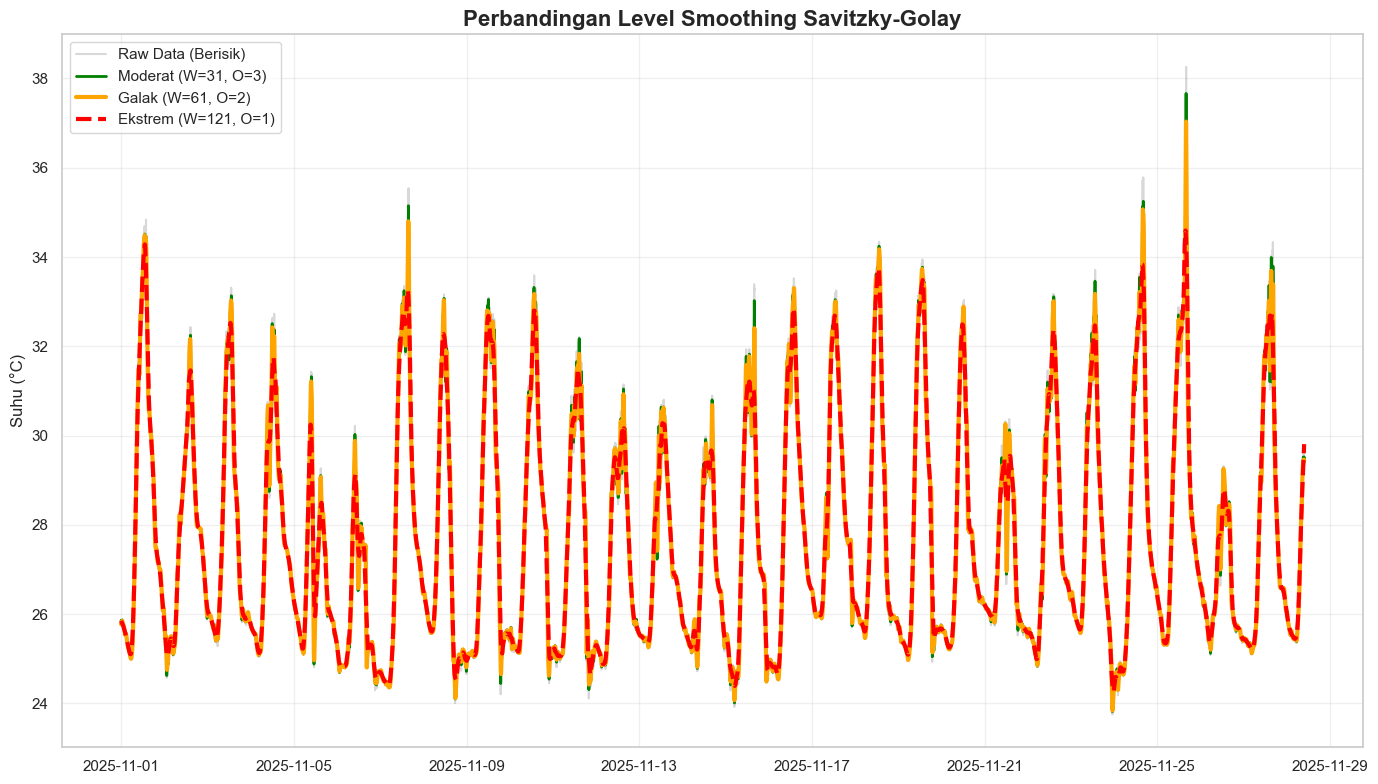

In [128]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Asumsi: df_smooth sudah ada datanya (data_menit_utc)
# Kita fokus ke kolom Temperature saja

# --- SKENARIO 1: MODERAT (Yang Anda pakai sekarang) ---
# Window: 31 menit, Order: 3 (Masih menangkap detail kecil)
df_smooth['temp_moderate'] = savgol_filter(df_smooth['temperature'], window_length=31, polyorder=3)

# --- SKENARIO 2: GALAK (Strong) ---
# Window: 61 menit (1 Jam), Order: 2 (Lebih kaku)
df_smooth['temp_galak'] = savgol_filter(df_smooth['temperature'], window_length=61, polyorder=2)

# --- SKENARIO 3: EKSTREM (Very Strong) ---
# Window: 121 menit (2 Jam), Order: 1 (Hampir lurus)
# Ini cocok untuk melihat "Trend Harian" tanpa peduli perubahan sesaat
df_smooth['temp_ekstrem'] = savgol_filter(df_smooth['temperature'], window_length=121, polyorder=1)

# --- VISUALISASI ---
# Convert ke WIB biar enak dilihat
df_plot = df_smooth.tz_convert('Asia/Jakarta')

fig, ax = plt.subplots(figsize=(14, 8))

# 1. Data Asli (Abu-abu transparan)
ax.plot(df_plot.index, df_plot['temperature'], color='gray', alpha=0.3, label='Raw Data (Berisik)')

# 2. Moderat (Hijau)
ax.plot(df_plot.index, df_plot['temp_moderate'], color='green', linewidth=2, label='Moderat (W=31, O=3)')

# 3. Galak (Oranye)
ax.plot(df_plot.index, df_plot['temp_galak'], color='orange', linewidth=3, label='Galak (W=61, O=2)')

# 4. Ekstrem (Merah)
ax.plot(df_plot.index, df_plot['temp_ekstrem'], color='red', linewidth=3, linestyle='--', label='Ekstrem (W=121, O=1)')

ax.set_title('Perbandingan Level Smoothing Savitzky-Golay', fontsize=16, fontweight='bold')
ax.set_ylabel('Suhu (°C)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

--- Data Setelah Smoothing (UTC) ---
                           temperature  temperature_smooth  rain_mm
timestamp                                                          
2025-11-28 05:30:00+00:00     32.53834           32.583273      0.0
2025-11-28 05:31:00+00:00     32.63981           32.584593      0.0
2025-11-28 05:32:00+00:00     32.67185           32.585348      0.0
2025-11-28 05:33:00+00:00     32.79736           32.585538      0.0
2025-11-28 05:34:00+00:00     32.82674           32.585162      0.0


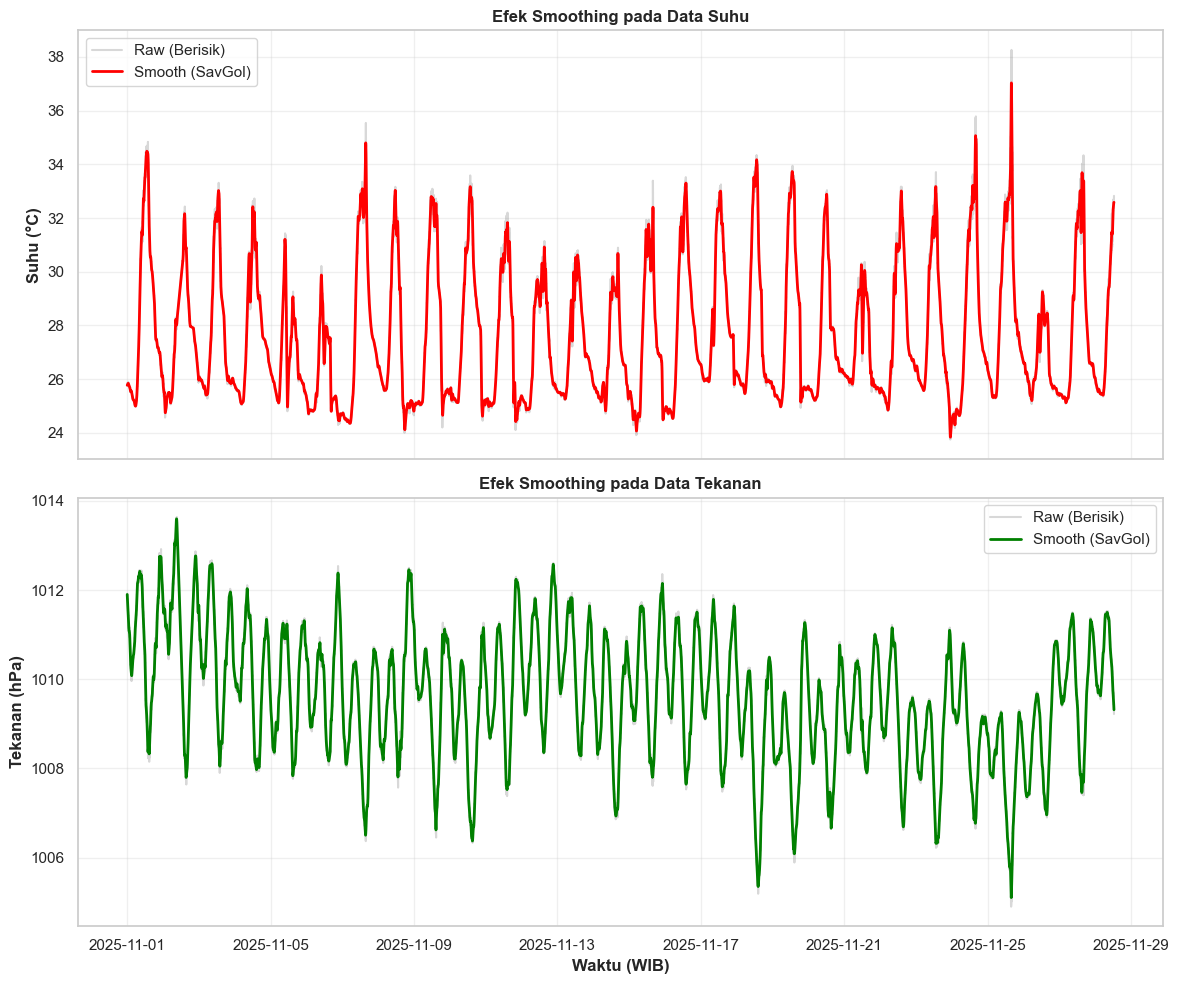

In [129]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. PERSIAPAN DATA ---
# Gunakan data_menit_utc yang sudah Anda buat sebelumnya
df_smooth = data_menit_utc.copy()

# --- 2. ISI DATA KOSONG (Prasyarat Smoothing) ---
# Algoritma smoothing matematika (seperti SavGol) TIDAK BISA bekerja jika ada NaN.
# Jadi kita harus interpolate dulu khusus untuk variabel kontinu.
cols_kontinu = ['temperature', 'humidity', 'pressure', 'dew', 'volt']

# Interpolasi 'time' agar garisnya nyambung natural sebelum dihaluskan
df_smooth[cols_kontinu] = df_smooth[cols_kontinu].interpolate(method='time')

# (Opsional) Jika masih ada NaN di awal/akhir data, gunakan bfill/ffill
df_smooth[cols_kontinu] = df_smooth[cols_kontinu].bfill().ffill()

# --- 3. PROSES SMOOTHING (SAVITZKY-GOLAY) ---
# Parameter:
# - window_length: 31 (artinya melihat jendela data 31 menit). Harus Ganjil!
# - polyorder: 3 (mengikuti bentuk kurva kubik, luwes).

for col in cols_kontinu:
    # Buat kolom baru berakhiran '_smooth'
    df_smooth[f'{col}_smooth'] = savgol_filter(df_smooth[col], window_length=61, polyorder=2)

# --- 4. CEK HASILNYA ---
print("--- Data Setelah Smoothing (UTC) ---")
print(df_smooth[['temperature', 'temperature_smooth', 'rain_mm']].tail())

# --- 5. VISUALISASI PERBANDINGAN (Raw vs Smooth) ---
# Kita convert ke WIB dulu biar enak dilihat grafiknya
df_plot = df_smooth.tz_convert('Asia/Jakarta')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Suhu (Smoothing vs Raw)
ax1.plot(df_plot.index, df_plot['temperature'], color='gray', alpha=0.3, label='Raw (Berisik)')
ax1.plot(df_plot.index, df_plot['temperature_smooth'], color='red', linewidth=2, label='Smooth (SavGol)')
ax1.set_ylabel('Suhu (°C)', fontweight='bold')
ax1.set_title('Efek Smoothing pada Data Suhu', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Tekanan (Smoothing vs Raw)
ax2.plot(df_plot.index, df_plot['pressure'], color='gray', alpha=0.3, label='Raw (Berisik)')
ax2.plot(df_plot.index, df_plot['pressure_smooth'], color='green', linewidth=2, label='Smooth (SavGol)')
ax2.set_ylabel('Tekanan (hPa)', fontweight='bold')
ax2.set_xlabel('Waktu (WIB)', fontweight='bold')
ax2.set_title('Efek Smoothing pada Data Tekanan', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

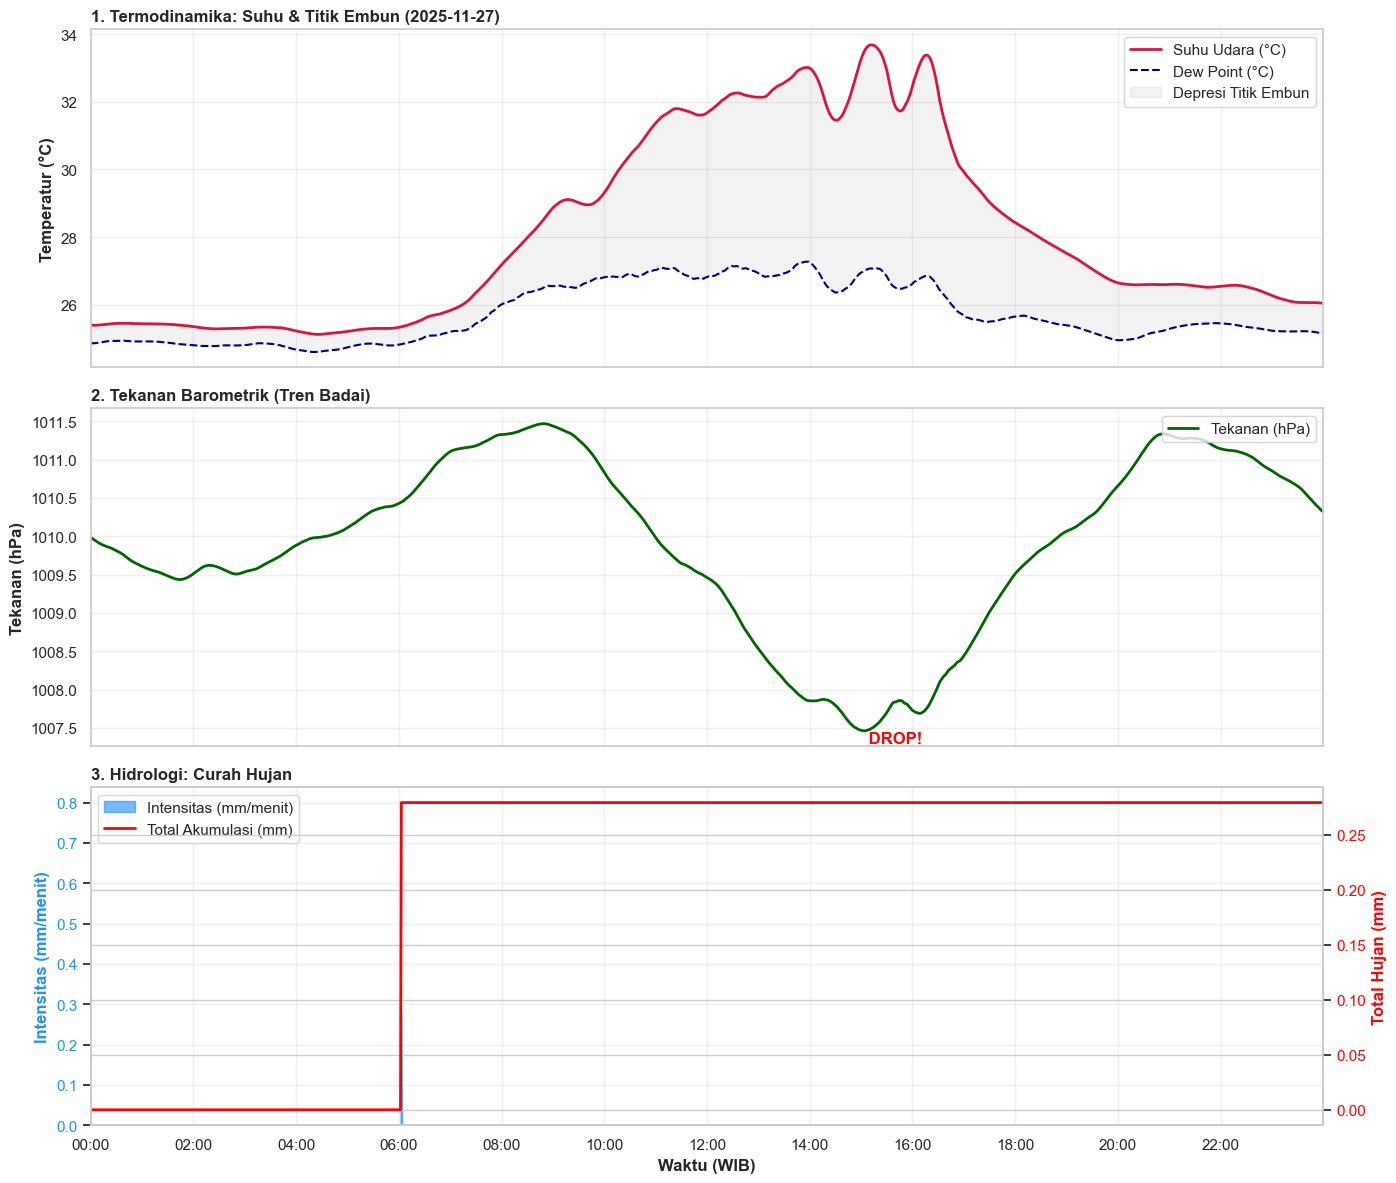

In [130]:
# --- 1. KONFIGURASI TANGGAL TARGET ---
target_date = '2025-11-27' # Ganti sesuai tanggal yang mau dicek

# --- 2. FILTER DATA ---
# Pastikan data dalam WIB
df_plot = df_smooth.tz_convert('Asia/Jakarta')

# Buat batas waktu 00:00 s.d 23:59 dengan Timezone WIB
start_time_aware = pd.Timestamp(f"{target_date} 00:00:00").tz_localize('Asia/Jakarta')
end_time_aware = pd.Timestamp(f"{target_date} 23:59:59").tz_localize('Asia/Jakarta')

# Slice data (Potong sesuai tanggal)
daily_data = df_plot.loc[start_time_aware:end_time_aware].copy()

if daily_data.empty:
    print(f"❌ Tidak ada data untuk tanggal {target_date}")
else:
    # [SOLUSI UTAMA] BUANG TIMEZONE SEBELUM PLOTTING
    # Ini memaksa jam 00:00 WIB menjadi jam 00:00 "Polos" agar grafik tidak geser
    daily_data.index = daily_data.index.tz_localize(None)
    
    # Hitung Akumulasi Harian Khusus Hari Itu (Reset dari 0)
    daily_data['rain_accum'] = daily_data['rain_mm'].cumsum()
    
    # --- 3. VISUALISASI DASHBOARD ---
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # ============================================================
    # PANEL 1: TERMODINAMIKA (Suhu vs Dew Point)
    # ============================================================
    # Plot Suhu (Smooth)
    ax1.plot(daily_data.index, daily_data['temperature_smooth'], 
             color='crimson', linewidth=2, label='Suhu Udara (°C)')
    
    # Plot Dew Point (Smooth)
    col_dew = 'dew_smooth' if 'dew_smooth' in daily_data.columns else 'dew'
    ax1.plot(daily_data.index, daily_data[col_dew], 
             color='navy', linestyle='--', linewidth=1.5, label='Dew Point (°C)')
    
    # Arsiran Kelembapan
    ax1.fill_between(daily_data.index, daily_data['temperature_smooth'], daily_data[col_dew], 
                     color='gray', alpha=0.1, label='Depresi Titik Embun')

    ax1.set_ylabel('Temperatur (°C)', fontweight='bold')
    ax1.set_title(f'1. Termodinamika: Suhu & Titik Embun ({target_date})', loc='left', fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # ============================================================
    # PANEL 2: TEKANAN UDARA (Barometer)
    # ============================================================
    ax2.plot(daily_data.index, daily_data['pressure_smooth'], 
             color='darkgreen', linewidth=2, label='Tekanan (hPa)')
    
    ax2.set_ylabel('Tekanan (hPa)', fontweight='bold')
    ax2.set_title('2. Tekanan Barometrik (Tren Badai)', loc='left', fontweight='bold')
    
    # Highlight Tren Turun
    press_start = daily_data['pressure_smooth'].iloc[0]
    press_min = daily_data['pressure_smooth'].min()
    if (press_start - press_min) > 1.5:
        ax2.text(daily_data['pressure_smooth'].idxmin(), press_min, " DROP!", 
                 color='red', fontweight='bold', va='top')

    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # ============================================================
    # PANEL 3: CURAH HUJAN (Intensitas & Akumulasi)
    # ============================================================
    # Sumbu Kiri: Intensitas per Menit
    ax3.fill_between(daily_data.index, daily_data['rain_mm'], 0,
                     color='dodgerblue', alpha=0.6, label='Intensitas (mm/menit)')
    ax3.set_ylabel('Intensitas (mm/menit)', color='dodgerblue', fontweight='bold')
    ax3.tick_params(axis='y', labelcolor='dodgerblue')
    
    if daily_data['rain_mm'].max() > 0:
        ax3.set_ylim(0, daily_data['rain_mm'].max() * 3)

    # Sumbu Kanan: Total Akumulasi
    ax3_twin = ax3.twinx()
    ax3_twin.plot(daily_data.index, daily_data['rain_accum'], 
                  color='red', linewidth=2, label='Total Akumulasi (mm)')
    ax3_twin.set_ylabel('Total Hujan (mm)', color='red', fontweight='bold')
    ax3_twin.tick_params(axis='y', labelcolor='red')

    ax3.set_title('3. Hidrologi: Curah Hujan', loc='left', fontweight='bold')
    
    # Gabung Legend
    lines, labels = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines + lines2, labels + labels2, loc='upper left')
    ax3.grid(True, alpha=0.3)

    # ============================================================
    # FINISHING TOUCH (BATAS JAM NAIVE)
    # ============================================================
    # Buat batas jam 00:00 - 23:59 TANPA TIMEZONE (Naive)
    start_limit_naive = pd.Timestamp(f"{target_date} 00:00:00")
    end_limit_naive = pd.Timestamp(f"{target_date} 23:59:59")

    # Paksa grafik menampilkan rentang ini
    ax3.set_xlim(start_limit_naive, end_limit_naive)
    
    ax3.set_xlabel('Waktu (WIB)', fontsize=12, fontweight='bold')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax3.xaxis.set_major_locator(mdates.HourLocator(interval=2))

    plt.tight_layout()

    
    plt.show()

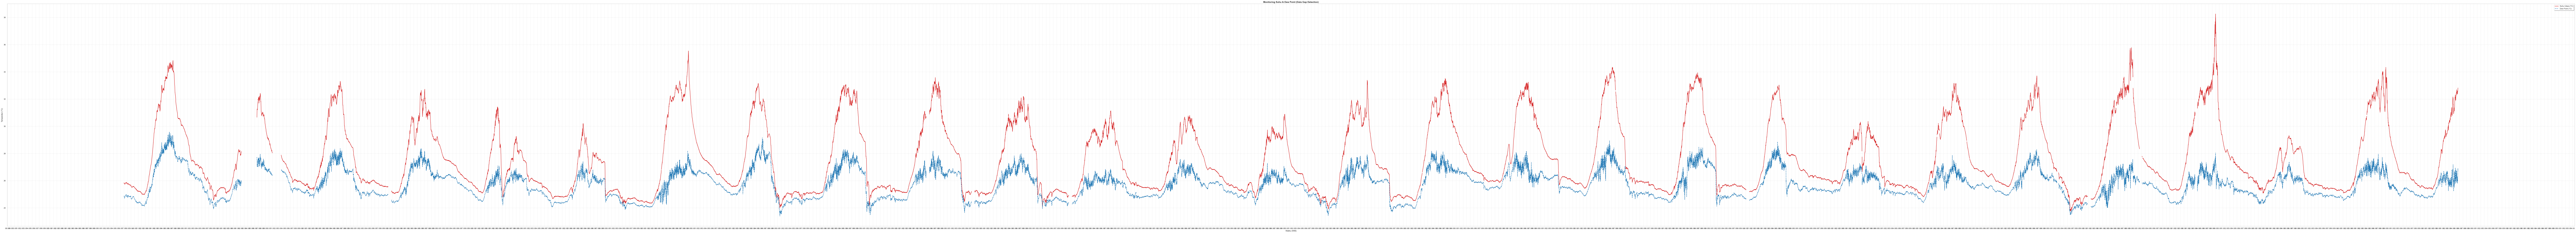

In [131]:
fig, ax = plt.subplots(figsize=(220, 20))

# 1. Plot Suhu (Garis Merah)
# Pandas/Matplotlib otomatis memutus garis jika ketemu NaN
ax.plot(data_menit_utc.index, data_menit_utc['temperature'], 
        color='tab:red', label='Suhu Udara (°C)', linewidth=2)

# 2. Plot Dew Point (Garis Biru Putus-putus)
ax.plot(data_menit_utc.index, data_menit_utc['dew'], 
        color='tab:blue', label='Dew Point (°C)', linestyle='--', linewidth=2)

# 3. Percantik Tampilan
ax.set_title('Monitoring Suhu & Dew Point (Data Gap Detection)', fontsize=14, fontweight='bold')
ax.set_ylabel('Temperatur (°C)', fontsize=12)
ax.set_xlabel('Waktu (WIB)', fontsize=12)
ax.grid(True, which='both', linestyle='--', alpha=0.6)
ax.legend(loc='upper right', frameon=True, shadow=True)

# Format Jam di Sumbu X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1)) # Label tiap jam (sesuaikan)

plt.tight_layout()
plt.show()

Menampilkan plot perbandingan per jam...


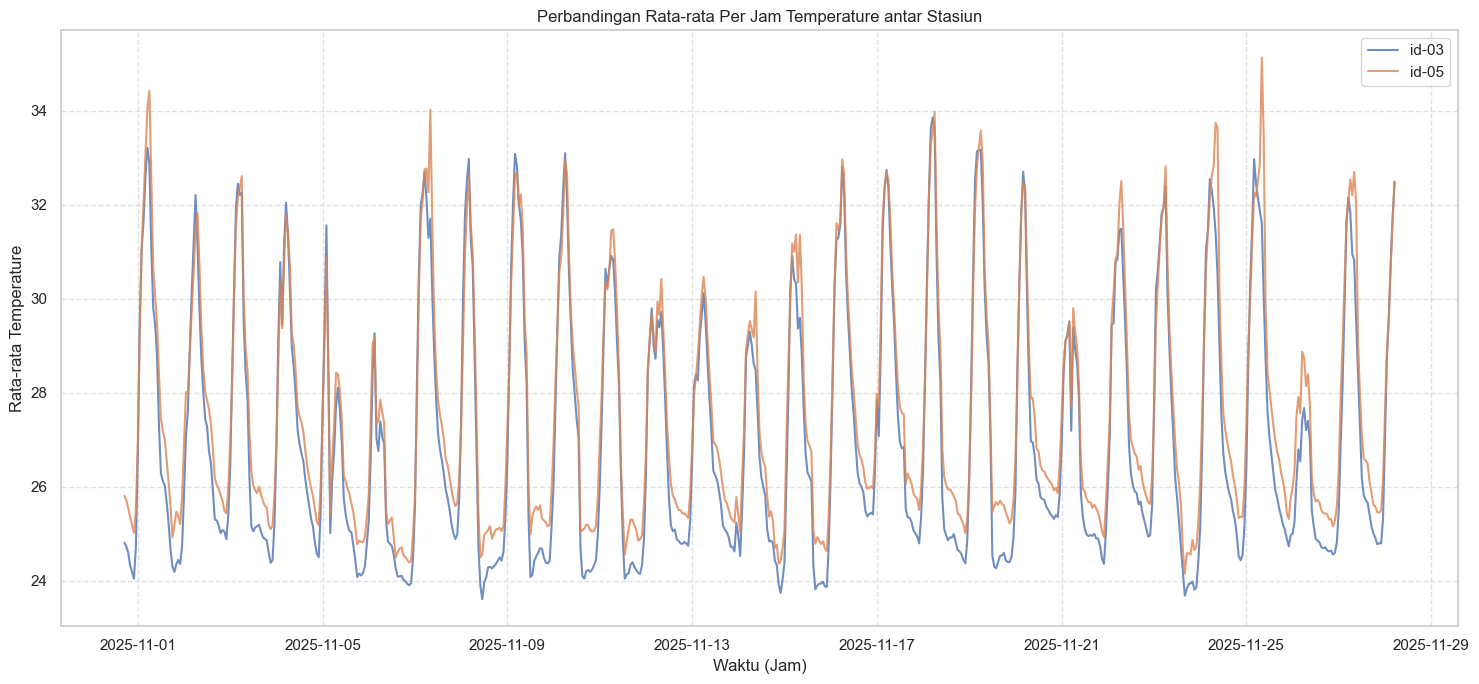

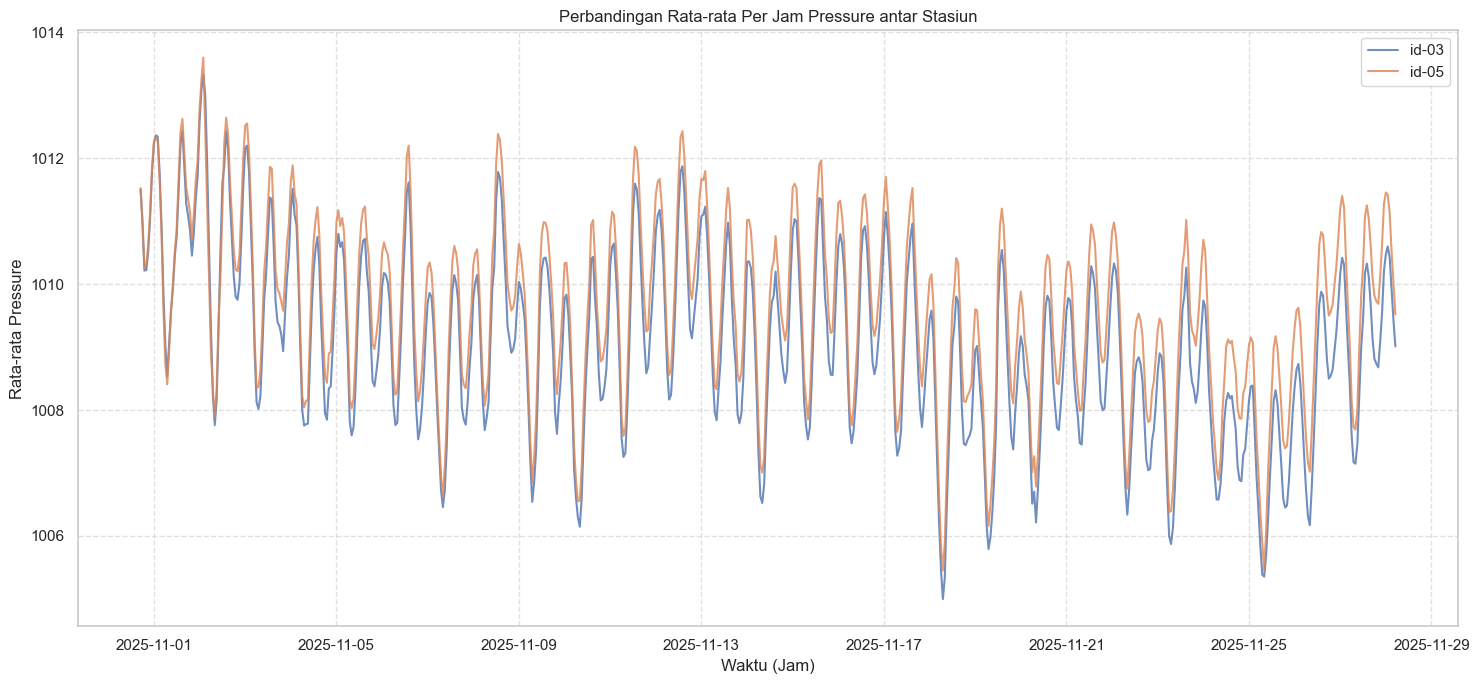

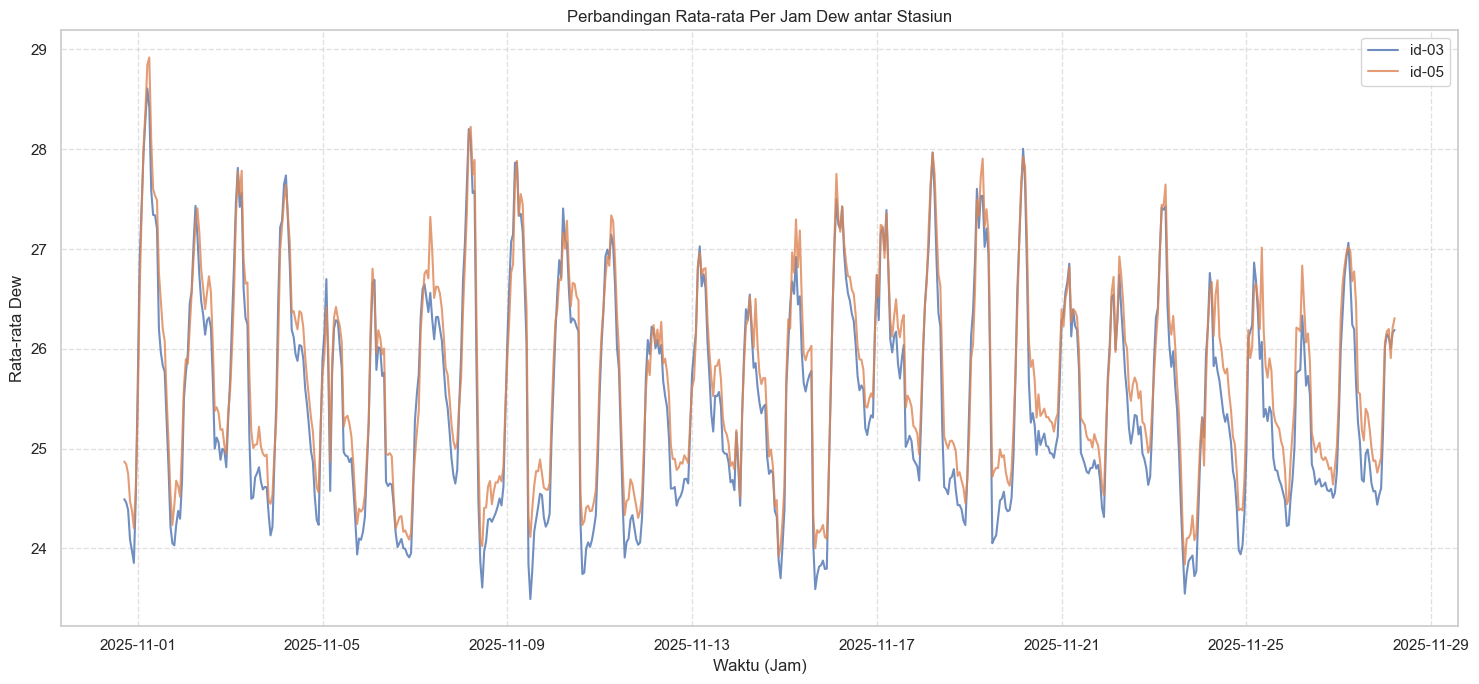

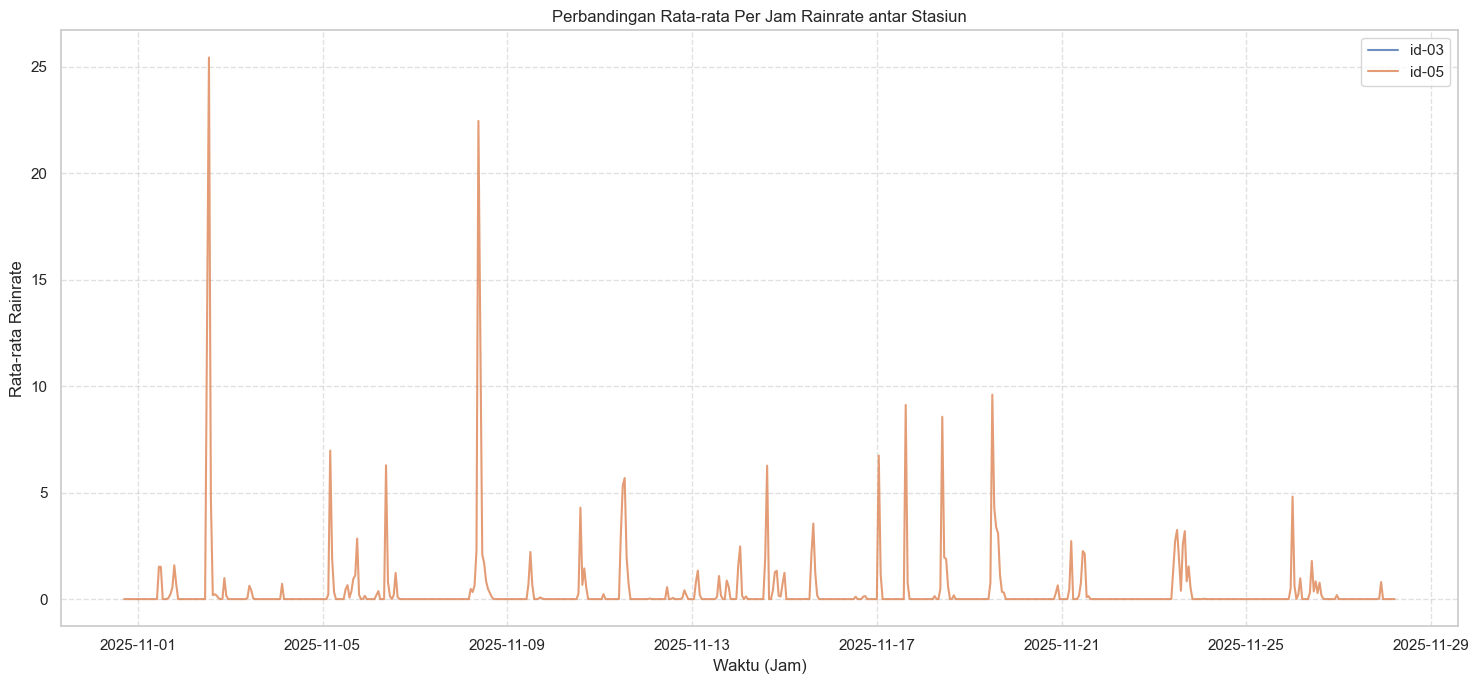


Menampilkan plot perbandingan per hari...


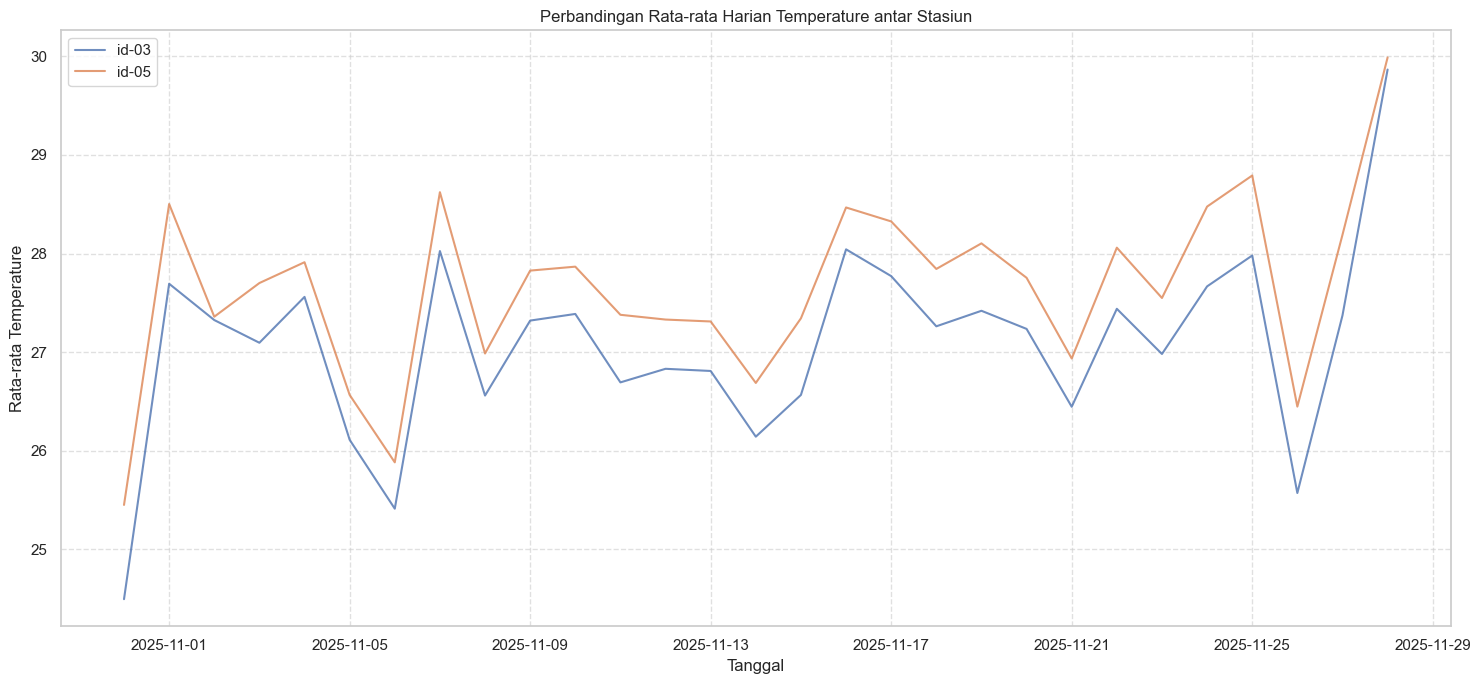

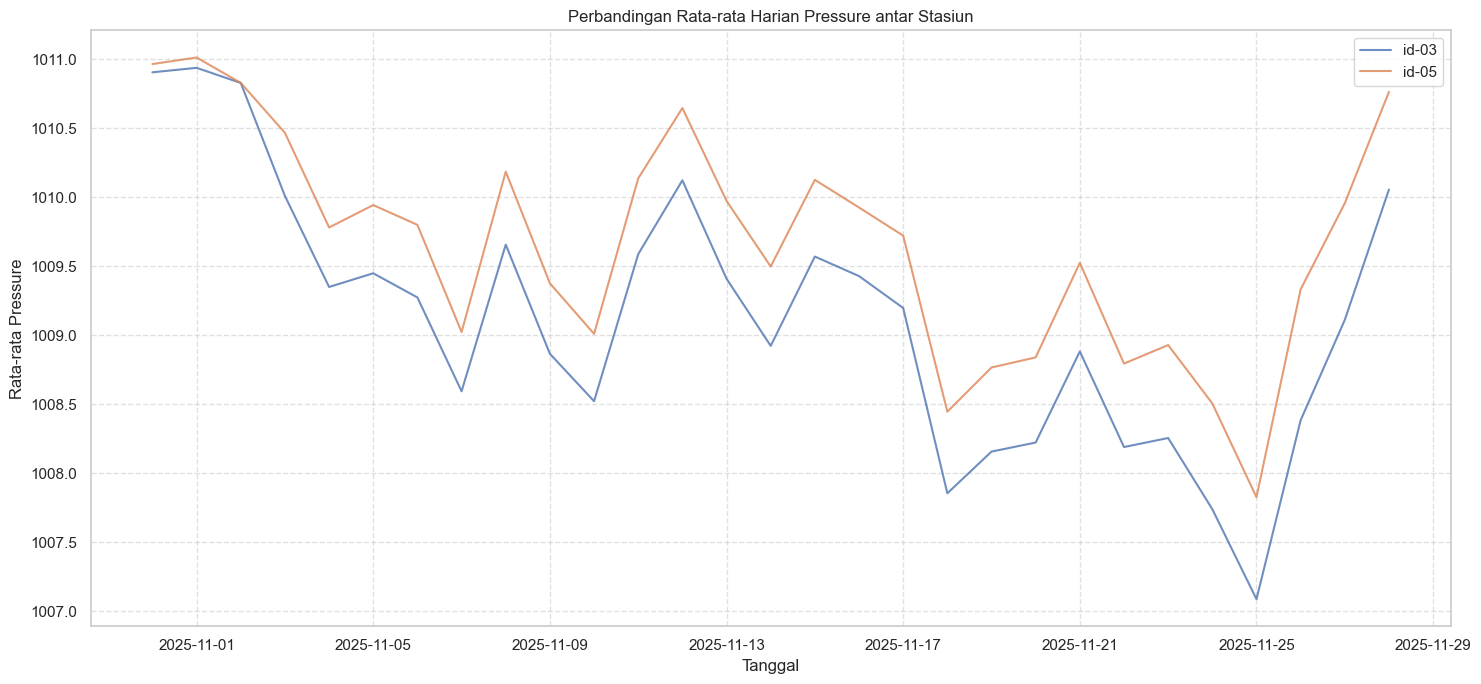

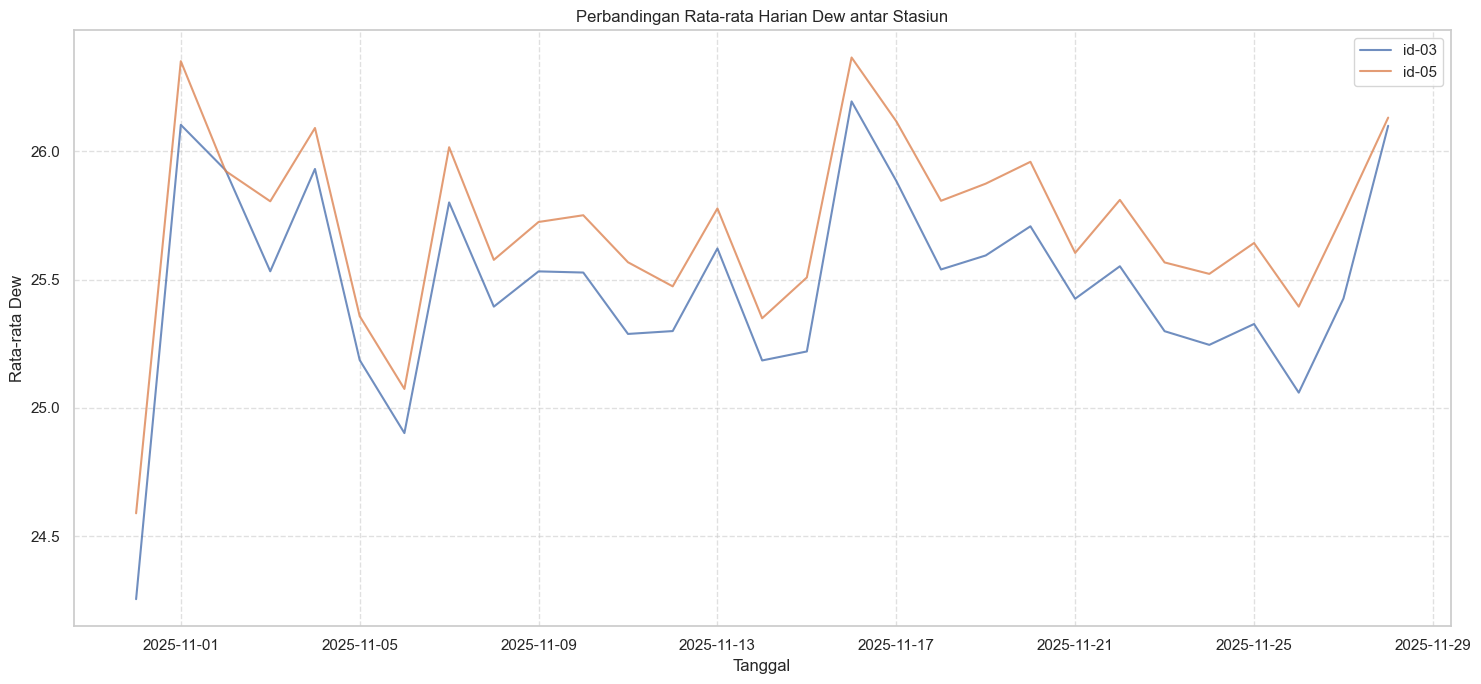

In [132]:
# Membuat Plot Rata-rata PER JAM ---
# Cukup atur freq='h'
print("Menampilkan plot perbandingan per jam...")
plot_station_trends(weather_dataframes, 'temperature', freq='h')
plot_station_trends(weather_dataframes, 'pressure', freq='h')
plot_station_trends(weather_dataframes, 'dew', freq='h')
plot_station_trends(weather_dataframes, 'rainrate', freq='h')


# Membuat Plot Rata-rata PER HARI ---
# Gunakan nilai default freq='d' atau tulis secara eksplisit
print("\nMenampilkan plot perbandingan per hari...")
plot_station_trends(weather_dataframes, 'temperature', freq='d')
plot_station_trends(weather_dataframes, 'pressure', freq='d')
plot_station_trends(weather_dataframes, 'dew', freq='d')

In [133]:

# --- 1. PERSIAPAN DATA ---
df = cuaca3.copy()
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').sort_index()

if df.index.tz is None:
    df = df.tz_localize('UTC')
# Kita proses di UTC dulu biar aman
# (Nanti di visualisasi baru convert ke Asia/Jakarta)

# --- 2. ALGORITMA SMART RESET (Menghitung Hujan Jam-jaman) ---

# A. Pastikan urutan waktu rapat (per menit)
df_menit = df['rainrate'].resample('1min').ffill()

# B. Hitung Selisih
delta = df_menit.diff()

# C. Logika Smart Reset (Handle Reset di tengah jam)
# Jika delta positif -> Hujan biasa
# Jika delta negatif (Reset) -> Ambil nilai saat itu
hujan_murni = np.where(delta >= 0, delta, df_menit)

# D. Masukkan ke DataFrame
df_bersih = pd.DataFrame({'hujan_mm': hujan_murni}, index=df_menit.index).fillna(0)

# E. AGREGASI KE JAM (Pakai SUM karena ini sudah tetesan murni)
jam_hujan = df_bersih['hujan_mm'].resample('h').sum()

# --- 3. PROSES SUHU (Tetap pakai Mean/Max/Min) ---
suhu_data = df['temperature'].resample('h') # Grouping dulu
suhu_rata = suhu_data.mean()
suhu_maks = suhu_data.max()
suhu_mini = suhu_data.min()

# --- 4. GABUNGKAN JADI DATAFRAME UTAMA ---
data_meteorologi = pd.DataFrame({
    'laju_hujan': jam_hujan,  # Ini hasil Smart Reset (.sum)
    'rata_suhu': suhu_rata,
    'suhu_maks': suhu_maks,
    'suhu_mini': suhu_mini
})

# Interpolasi suhu yang bolong
data_meteorologi[['rata_suhu', 'suhu_maks', 'suhu_mini']] = \
    data_meteorologi[['rata_suhu', 'suhu_maks', 'suhu_mini']].interpolate(method='time')

print("--- Data Siap (Metode Smart Reset) ---")
print(data_meteorologi.tail(10))

--- Data Siap (Metode Smart Reset) ---
                           laju_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                             
2025-11-27 20:00:00+00:00      0.0000  25.461335   25.51270   25.40589
2025-11-27 21:00:00+00:00      0.2794  25.455114   25.51270   25.40055
2025-11-27 22:00:00+00:00      1.3970  25.496236   25.70496   25.35249
2025-11-27 23:00:00+00:00      0.0000  26.137025   26.74105   25.68894
2025-11-28 00:00:00+00:00      0.0000  27.582386   28.31388   26.77844
2025-11-28 01:00:00+00:00      0.0000  28.854173   29.60365   27.98543
2025-11-28 02:00:00+00:00      0.0000  29.650220   30.25521   29.21378
2025-11-28 03:00:00+00:00      0.0000  30.721447   31.38743   30.23918
2025-11-28 04:00:00+00:00      0.0000  31.674844   32.31403   30.91211
2025-11-28 05:00:00+00:00      0.0000  32.488136   32.82674   32.19920


In [134]:
data_meteorologi["laju_hujan"].sum()

np.float64(503.7582)

In [135]:
data_meteorologi.tail(50)

laju_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                             
2025-11-26 04:00:00+00:00      1.1176  27.569123   28.07889   26.86389
2025-11-26 05:00:00+00:00      0.0000  28.871620   29.31525   28.03349
2025-11-26 06:00:00+00:00      0.0000  28.741221   29.13100   28.04417
2025-11-26 07:00:00+00:00      0.0000  28.141642   28.35394   27.96140
2025-11-26 08:00:00+00:00      0.0000  28.392587   28.53819   28.26048
2025-11-26 09:00:00+00:00      2.5146  27.726940   28.38598   26.59151
2025-11-26 10:00:00+00:00      1.9558  26.173965   26.57015   25.98268
2025-11-26 11:00:00+00:00      0.8382  25.853261   26.03876   25.73167
2025-11-26 12:00:00+00:00      1.3970  25.692771   25.77707   25.57946
2025-11-26 13:00:00+00:00      1.1176  25.722857   25.77173   25.66758
2025-11-26 14:00:00+00:00      2.2352  25.653962   25.71030   25.60883
2025-11-26 15:00:00+00:00      0.2794  25.503180   25.65957   25.34715
2025-11-26 16:00:00+00:00      0.2794  25.437490   25.49935   25.37118
2025-11-26 17:00:00+00:00      0.0000  25.430767   25.47265   25.37385
2025-11-26 18:00:00+00:00      0.0000  25.412382   25.46197   25.34180
2025-11-26 19:00:00+00:00      0.0000  25.305311   25.37385   25.26170
2025-11-26 20:00:00+00:00      0.0000  25.313971   25.36851   25.25903
2025-11-26 21:00:00+00:00      0.0000  25.158678   25.28306   25.09079
2025-11-26 22:00:00+00:00      0.0000  25.281277   25.32845   25.17624
2025-11-26 23:00:00+00:00      0.2794  25.581865   25.88388   25.32044
2025-11-27 00:00:00+00:00      0.0000  26.380204   27.14160   25.66224
2025-11-27 01:00:00+00:00      0.0000  27.967447   28.86130   27.16830
2025-11-27 02:00:00+00:00      0.0000  29.044687   29.29389   28.86130
2025-11-27 03:00:00+00:00      0.0000  30.354778   31.33936   29.29656
2025-11-27 04:00:00+00:00      0.0000  31.667455   31.96956   31.31266
2025-11-27 05:00:00+00:00      0.0000  32.103964   32.53834   31.55032
2025-11-27 06:00:00+00:00      0.0000  32.537003   33.35279   31.83070
2025-11-27 07:00:00+00:00      0.0000  32.200097   33.46494   31.02693
2025-11-27 08:00:00+00:00      0.0000  32.689658   34.02571   31.06966
2025-11-27 09:00:00+00:00      0.0000  32.068271   34.33547   30.00954
2025-11-27 10:00:00+00:00      0.0000  29.118893   30.08698   28.42870
2025-11-27 11:00:00+00:00      0.0000  27.980710   28.43938   27.54749
2025-11-27 12:00:00+00:00      0.0000  27.073243   27.52079   26.67696
2025-11-27 13:00:00+00:00      0.0000  26.598012   26.64492   26.56481
2025-11-27 14:00:00+00:00      0.0000  26.556979   26.62356   26.47402
2025-11-27 15:00:00+00:00      0.0000  26.495473   26.60754   26.29778
2025-11-27 16:00:00+00:00      0.0000  26.107206   26.29778   26.03075
2025-11-27 17:00:00+00:00      0.0000  25.872309   26.08949   25.73701
2025-11-27 18:00:00+00:00      0.0000  25.617290   25.75571   25.50736
2025-11-27 19:00:00+00:00      0.0000  25.581329   25.66224   25.49668
2025-11-27 20:00:00+00:00      0.0000  25.461335   25.51270   25.40589
2025-11-27 21:00:00+00:00      0.2794  25.455114   25.51270   25.40055
2025-11-27 22:00:00+00:00      1.3970  25.496236   25.70496   25.35249
2025-11-27 23:00:00+00:00      0.0000  26.137025   26.74105   25.68894
2025-11-28 00:00:00+00:00      0.0000  27.582386   28.31388   26.77844
2025-11-28 01:00:00+00:00      0.0000  28.854173   29.60365   27.98543
2025-11-28 02:00:00+00:00      0.0000  29.650220   30.25521   29.21378
2025-11-28 03:00:00+00:00      0.0000  30.721447   31.38743   30.23918
2025-11-28 04:00:00+00:00      0.0000  31.674844   32.31403   30.91211
2025-11-28 05:00:00+00:00      0.0000  32.488136   32.82674   32.19920

In [136]:
# Langkah 1: Resample data untuk mendapatkan nilai 'rainrate' maksimum per hari.
# Langkah 2: Resample harian (cut-off 00:00 UTC / 07:00 WIB)
hujan_harian = data_meteorologi['laju_hujan'].resample('d').sum()

# Langkah 3: Hitung statistik suhu harian
# Menggunakan UTC agar sinkron dengan periode hujan
suhu_data = data_meteorologi['rata_suhu']
suhu_rata_harian = suhu_data.resample('d').mean()
suhu_maks_harian = suhu_data.resample('d').max()
suhu_mini_harian = suhu_data.resample('d').min()

# Gabungkan ke DataFrame
data_klimat = pd.DataFrame({
    'curah_hujan': hujan_harian,
    'rata_suhu': suhu_rata_harian,
    'suhu_maks': suhu_maks_harian,
    'suhu_mini': suhu_mini_harian
})

# Kembalikan index ke WIB
#data_klimat = data_klimat.tz_convert('Asia/Jakarta')

# --- FILTER TANGGAL AGAR RAPI ---
# Menggunakan start_readable_date dan end_readable_date dari input pengguna
# Format asumsi: "DD-MM-YYYY HH:MM:SS"
#start_ts = pd.to_datetime(start_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').floor('D')
#end_ts = pd.to_datetime(end_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').ceil('D')

# Potong data yang di luar rentang
#data_klimat = data_klimat.loc[(data_klimat.index >= start_ts) & (data_klimat.index < end_ts)]

In [137]:
data_klimat.tail(20)

curah_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                              
2025-11-09 00:00:00+00:00       8.3820  27.822171  32.670163  24.992256
2025-11-10 00:00:00+00:00      13.9700  27.882089  32.966302  25.039966
2025-11-11 00:00:00+00:00      42.7482  27.284960  31.474234  24.555820
2025-11-12 00:00:00+00:00       5.3086  27.310656  30.416332  25.339688
2025-11-13 00:00:00+00:00      13.4112  27.310357  30.462869  25.243724
2025-11-14 00:00:00+00:00      33.8074  26.685707  30.150174  24.367404
2025-11-15 00:00:00+00:00      10.6172  27.342365  31.366381  24.629980
2025-11-16 00:00:00+00:00       1.6764  28.461050  32.961318  25.960075
2025-11-17 00:00:00+00:00      21.7932  28.321011  32.689745  25.508965
2025-11-18 00:00:00+00:00      26.2636  27.855797  33.976221  25.014687
2025-11-19 00:00:00+00:00      51.9684  27.986871  33.574692  25.221542
2025-11-20 00:00:00+00:00       1.1176  27.753508  32.463481  25.861896
2025-11-21 00:00:00+00:00      16.7640  26.931396  29.798759  24.929771
2025-11-22 00:00:00+00:00       0.0000  28.068486  32.501309  25.638029
2025-11-23 00:00:00+00:00      37.7190  27.428444  32.814450  24.152705
2025-11-24 00:00:00+00:00       0.2794  28.477340  33.738918  25.335603
2025-11-25 00:00:00+00:00       4.4704  28.845127  35.128024  25.313942
2025-11-26 00:00:00+00:00      19.2786  26.445867  28.871620  25.158678
2025-11-27 00:00:00+00:00       1.6764  28.190197  32.689658  25.455114
2025-11-28 00:00:00+00:00       0.0000  30.161868  32.488136  27.582386

Variabel start_ts/end_ts tidak ditemukan, menampilkan semua data.


Grafik Hourly berhasil disimpan di: plots\Meteo_Chart_Hourly_id-05_2025-11-01_sd_2025-11-28.png


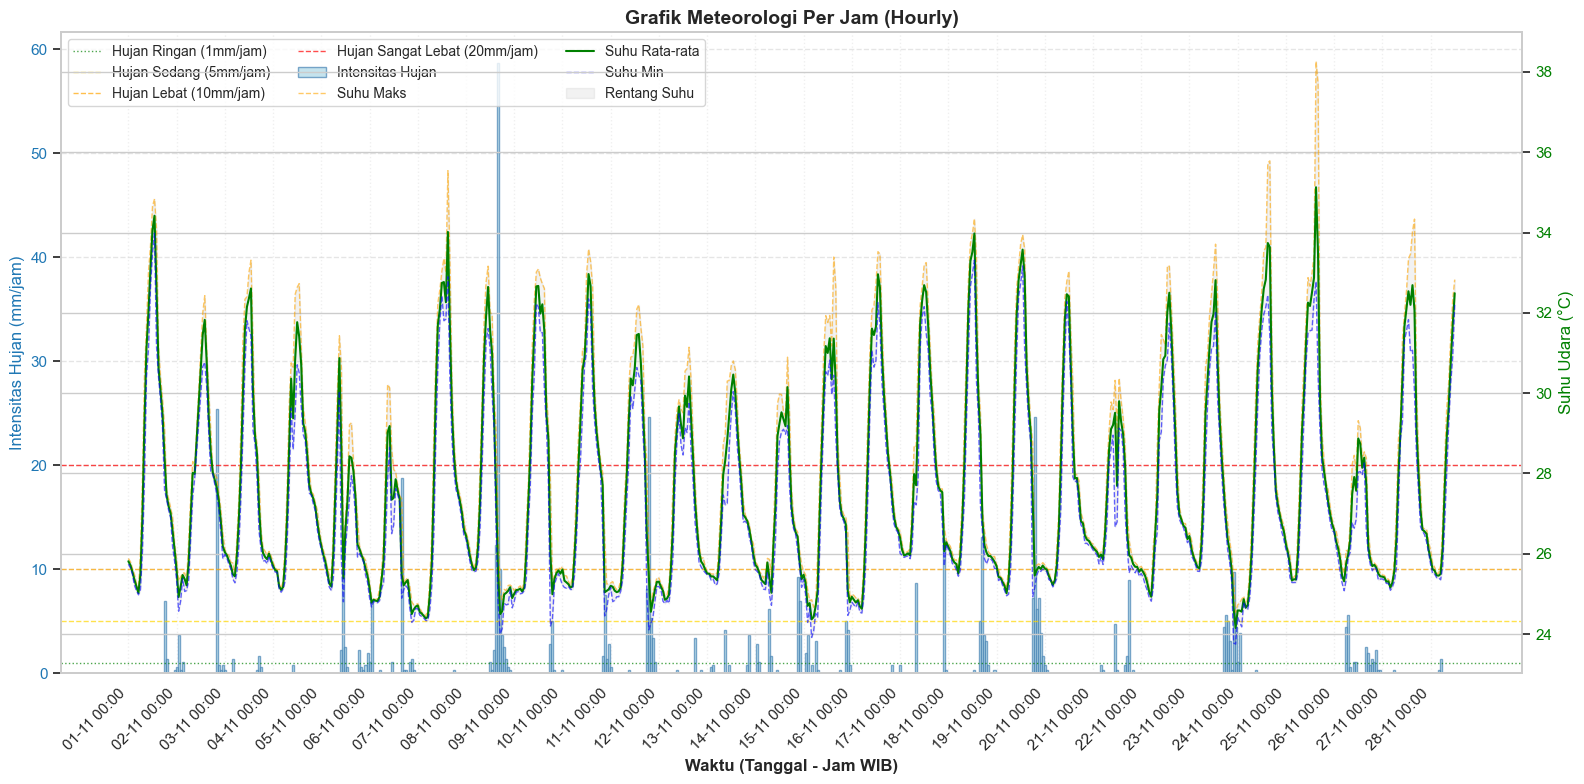

In [138]:
# --- VISUALISASI DATA PER JAM (HOURLY) ---

# 1. Persiapan Data
# Copy data agar tidak merusak variabel asli
df_plot_hourly = data_meteorologi.copy()

# Konversi ke WIB (Asia/Jakarta) agar jam sesuai dengan waktu lokal
# Cek apakah index sudah punya timezone
if df_plot_hourly.index.tz is None:
	# Jika naive, asumsikan UTC (karena output resample sebelumnya UTC) lalu convert
	df_plot_hourly = df_plot_hourly.tz_localize('UTC').tz_convert('Asia/Jakarta')
else:
	# Jika sudah aware, langsung convert
	df_plot_hourly = df_plot_hourly.tz_convert('Asia/Jakarta')

# Filter tanggal sesuai rentang yang ditentukan sebelumnya (start_ts, end_ts dari Cell 22)
# Pastikan start_ts dan end_ts ada, jika tidak skip filter
try:
	df_plot_hourly = df_plot_hourly.loc[(df_plot_hourly.index >= start_iso) & (df_plot_hourly.index < end_iso)]
except NameError:
	print("Variabel start_ts/end_ts tidak ditemukan, menampilkan semua data.")

# 2. Setup Plot
fig, ax1 = plt.subplots(figsize=(16, 8)) # Lebar diperbesar karena data per jam padat

# Buat array X-axis (angka urut) agar bar chart rapi
x_axis = range(len(df_plot_hourly))
# Buat label tanggal string untuk tick
date_labels = df_plot_hourly.index.strftime('%d-%m %H:%M')

# 3. Plot Curah Hujan (Bar chart) di ax1
# Gunakan 'laju_hujan' dari data_meteorologi
ax1.bar(x_axis, df_plot_hourly['laju_hujan'], color='lightblue', edgecolor='steelblue', label='Intensitas Hujan', alpha=0.7, width=1.0)

ax1.set_xlabel('Waktu (Tanggal - Jam WIB)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Intensitas Hujan (mm/jam)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Atur X-Ticks: Tampilkan label setiap 24 jam (sehari sekali) agar tidak tumpang tindih
# atau setiap 12 jam jika rentang data pendek. Kita coba setiap 24 jam.
interval_tick = 24 
ax1.set_xticks(x_axis[::interval_tick])
ax1.set_xticklabels(date_labels[::interval_tick], rotation=45, ha='right')

# Garis batas kategori hujan PER JAM (BMKG)
# Kategori intensitas hujan per jam: Ringan (1-5), Sedang (5-10), Lebat (10-20), Sangat Lebat (>20)
ax1.axhline(y=1, color='green', linestyle=':', linewidth=1, alpha=0.7, label='Hujan Ringan (1mm/jam)')
ax1.axhline(y=5, color='gold', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sedang (5mm/jam)')
ax1.axhline(y=10, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Lebat (10mm/jam)')
ax1.axhline(y=20, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sangat Lebat (20mm/jam)')

# 4. Membuat secondary y-axis (ax2) untuk Suhu
ax2 = ax1.twinx()

# A. Plot Suhu Maksimum (Jingga)
ax2.plot(x_axis, df_plot_hourly['suhu_maks'], color='orange', linestyle='--', linewidth=1, alpha=0.6, label='Suhu Maks')

# B. Plot Suhu Rata-rata (Hijau)
ax2.plot(x_axis, df_plot_hourly['rata_suhu'], color='green', linewidth=1.5, label='Suhu Rata-rata')

# C. Plot Suhu Minimum (Biru)
ax2.plot(x_axis, df_plot_hourly['suhu_mini'], color='blue', linestyle='--', linewidth=1, alpha=0.6, label='Suhu Min')

# D. Arsiran Rentang Suhu
ax2.fill_between(x_axis, df_plot_hourly['suhu_mini'], df_plot_hourly['suhu_maks'], color='gray', alpha=0.1, label='Rentang Suhu')

ax2.set_ylabel('Suhu Udara (°C)', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Judul dan Grid
ax1.set_title('Grafik Meteorologi Per Jam (Hourly)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.grid(axis='x', linestyle=':', alpha=0.3)

# Menggabungkan Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1), ncol=3, fontsize='small', frameon=True)

plt.tight_layout()

# --- Menyimpan Plot ---
output_folder = 'plots'
if not os.path.exists(output_folder):
	os.makedirs(output_folder)

tgl_awal_str = df_plot_hourly.index[0].strftime('%Y-%m-%d')
tgl_akhir_str = df_plot_hourly.index[-1].strftime('%Y-%m-%d')
filename_hourly = f"Meteo_Chart_Hourly_id-05_{tgl_awal_str}_sd_{tgl_akhir_str}.png"
filepath_hourly = os.path.join(output_folder, filename_hourly)

plt.savefig(filepath_hourly, dpi=300)
print(f"Grafik Hourly berhasil disimpan di: {filepath_hourly}")

plt.show()


Grafik berhasil disimpan di: plots\Meteo_Chart_id-05_2025-10-31_sd_2025-11-28.png


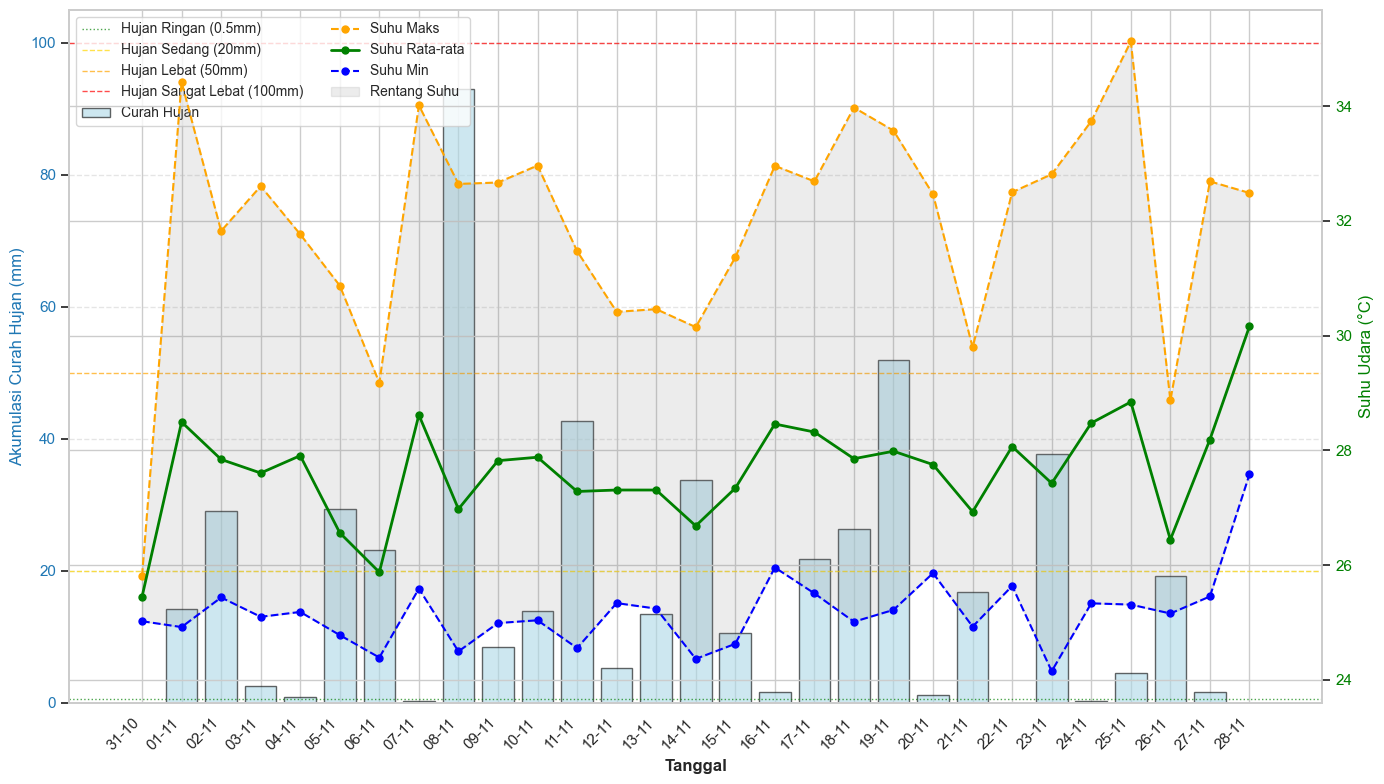

In [139]:
# --- VISUALISASI BARU ---

fig, ax1 = plt.subplots(figsize=(14, 8))

# 1. Plot Curah Hujan (Bar chart) di ax1
# Gunakan format tanggal string untuk sumbu X agar rapi
date_labels = data_klimat.index.strftime('%d-%m') 
ax1.bar(date_labels, data_klimat['curah_hujan'], color='lightblue', edgecolor='black', label='Curah Hujan', alpha=0.6)

ax1.set_xlabel('Tanggal', fontsize=12, fontweight='bold')
ax1.set_ylabel('Akumulasi Curah Hujan (mm)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Memiringkan label tanggal agar tidak tumpang tindih
plt.xticks(rotation=45, ha='right')

# Garis batas kategori hujan (BMKG)
ax1.axhline(y=0.5, color='green', linestyle=':', linewidth=1, alpha=0.7, label='Hujan Ringan (0.5mm)')
ax1.axhline(y=20, color='gold', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sedang (20mm)')
ax1.axhline(y=50, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Lebat (50mm)')
ax1.axhline(y=100, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sangat Lebat (100mm)')

# 2. Membuat secondary y-axis (ax2) untuk Suhu
ax2 = ax1.twinx()

# Kita plot garis menggunakan range(len) agar pas di tengah bar chart
x_axis = range(len(data_klimat))

# A. Plot Suhu Maksimum (Jingga)
ax2.plot(x_axis, data_klimat['suhu_maks'], color='orange', linestyle='--', marker='o', markersize=5, label='Suhu Maks')

# B. Plot Suhu Rata-rata (Hijau)
ax2.plot(x_axis, data_klimat['rata_suhu'], color='green', linewidth=2, marker='o', markersize=5, label='Suhu Rata-rata')

# C. Plot Suhu Minimum (Biru)
ax2.plot(x_axis, data_klimat['suhu_mini'], color='blue', linestyle='--', marker='o', markersize=5, label='Suhu Min')

# D. Arsiran Rentang Suhu (Diurnal Range) - Opsional tapi Bagus
# Memberikan efek visual rentang suhu hari itu
ax2.fill_between(x_axis, data_klimat['suhu_mini'], data_klimat['suhu_maks'], color='gray', alpha=0.15, label='Rentang Suhu')
ax2.set_ylabel('Suhu Udara (°C)', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Judul dan Grid
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Menggabungkan Legend dari kedua axis agar rapi
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Taruh legend di luar plot atau di posisi kosong
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize='small', frameon=True)

plt.tight_layout()

# --- Menyimpan Plot ---
output_folder = 'plots'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Ambil tanggal awal dan akhir dari index dataframe langsung (lebih aman)
tgl_awal = data_klimat.index[0].strftime('%Y-%m-%d')
tgl_akhir = data_klimat.index[-1].strftime('%Y-%m-%d')
filename = f"Meteo_Chart_id-05_{tgl_awal}_sd_{tgl_akhir}.png"
filepath = os.path.join(output_folder, filename)

plt.savefig(filepath, dpi=300)
print(f"Grafik berhasil disimpan di: {filepath}")

plt.show()

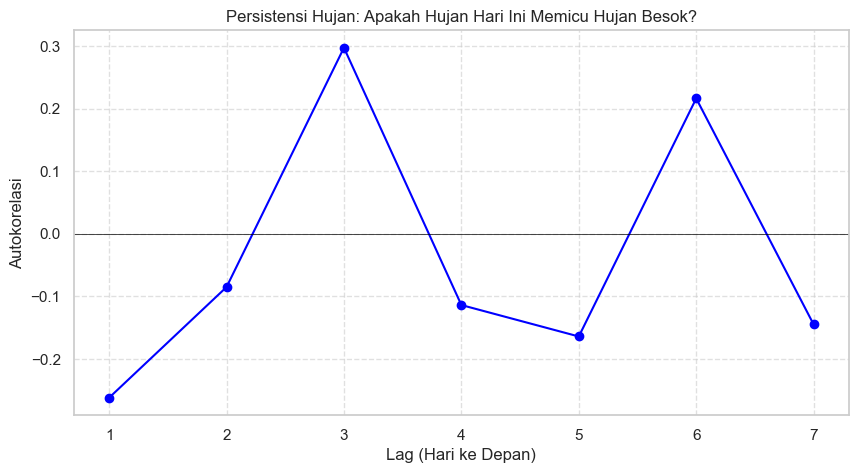

In [140]:
hasil_autokorelasi = []
max_lag = 7

for i in range(1, max_lag + 1):
    # Hujan Hari Ini vs Hujan Masa Depan
    future_rain = data_klimat['curah_hujan'].shift(-i)
    
    # Korelasi Hujan vs Hujan
    corr = data_klimat['curah_hujan'].corr(future_rain)
    hasil_autokorelasi.append(corr)
    
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_lag + 1), hasil_autokorelasi, marker='o', color='blue')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Lag (Hari ke Depan)')
plt.ylabel('Autokorelasi')
plt.title('Persistensi Hujan: Apakah Hujan Hari Ini Memicu Hujan Besok?')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Text(0.5, 0, 'Lama Hujan (Jam)')

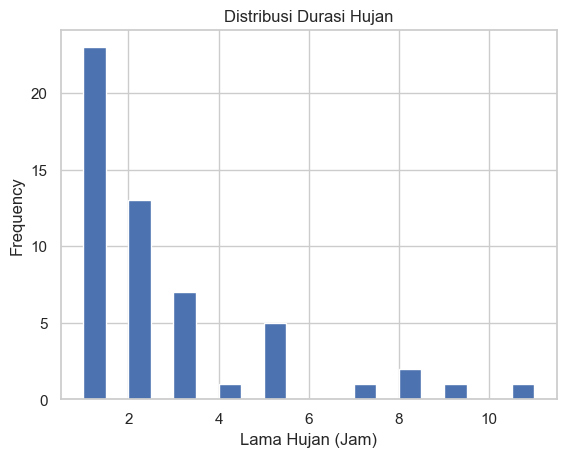

In [141]:
# Logika untuk mengelompokkan jam hujan berturut-turut
# (Kode agak kompleks, ini logika intinya)
data_meteorologi['is_rain'] = data_meteorologi['laju_hujan'] > 0
# Memberi ID unik untuk setiap blok kejadian hujan
data_meteorologi['storm_id'] = (data_meteorologi['is_rain'] != data_meteorologi['is_rain'].shift()).cumsum()

# Filter hanya yang hujan
badai = data_meteorologi[data_meteorologi['is_rain']].groupby('storm_id')

# Hitung durasi setiap badai
durasi_badai = badai.size()  # Dalam jam (karena data per jam)

# Histogram Durasi
durasi_badai.plot(kind='hist', bins=20, title='Distribusi Durasi Hujan')
plt.xlabel('Lama Hujan (Jam)')

Total Data Harian: 29 hari
Jumlah Hari Hujan: 24
Jumlah Hari Kering: 5

Matriks Kejadian (Count):
[[ 0.  4.]
 [ 4. 20.]]


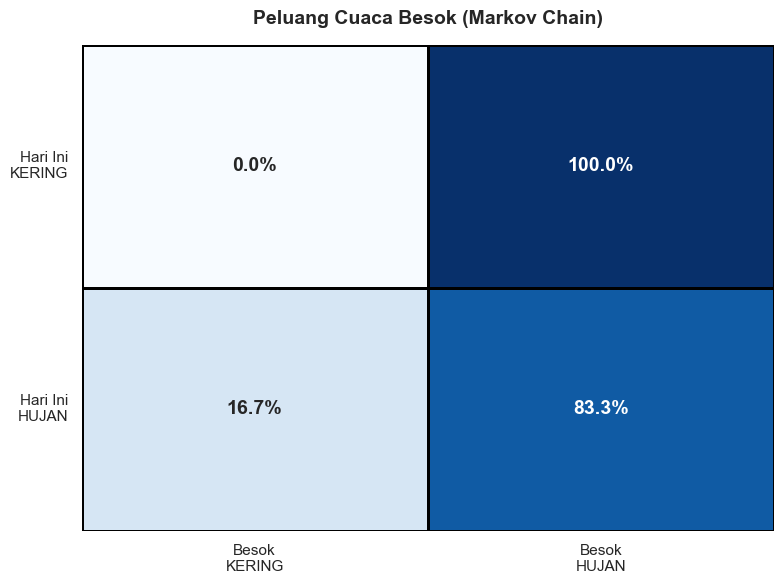

In [142]:
# --- 1. PERSIAPAN DATA ---
# Gunakan threshold 0.5 mm agar lebih valid secara meteorologis
threshold_hujan = 0.5
status_hujan = data_klimat['curah_hujan'].apply(lambda x: 1 if x >= threshold_hujan else 0).values

print(f"Total Data Harian: {len(status_hujan)} hari")
print(f"Jumlah Hari Hujan: {np.sum(status_hujan)}")
print(f"Jumlah Hari Kering: {len(status_hujan) - np.sum(status_hujan)}")

# --- 2. HITUNG TRANSISI (MANUAL) ---
jumlah_transisi = np.zeros((2, 2)) 

for t in range(len(status_hujan) - 1):
    state_sekarang = status_hujan[t]      
    state_besok    = status_hujan[t + 1]  
    jumlah_transisi[state_sekarang][state_besok] += 1

print("\nMatriks Kejadian (Count):")
print(jumlah_transisi)

# --- 3. HITUNG PROBABILITAS ---
matriks_probabilitas = np.zeros((2, 2))
total_per_state = jumlah_transisi.sum(axis=1)

for i in range(2):
    if total_per_state[i] > 0: # Mencegah bagi dengan nol
        for j in range(2):
            matriks_probabilitas[i][j] = jumlah_transisi[i][j] / total_per_state[i]

# --- 4. VISUALISASI ---
df_plot = pd.DataFrame(matriks_probabilitas, 
                       index=['Hari Ini\nKERING', 'Hari Ini\nHUJAN'],
                       columns=['Besok\nKERING', 'Besok\nHUJAN'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_plot, 
            annot=True, 
            fmt=".1%", # 1 desimal cukup (contoh: 58.3%)
            cmap="Blues", 
            linewidths=1, 
            linecolor='black',
            cbar=False, # Hilangkan colorbar biar simpel
            annot_kws={"size": 14, "weight": "bold"})

plt.title('Peluang Cuaca Besok (Markov Chain)', fontsize=14, fontweight='bold', pad=15)
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

--- Statistik Diurnal (WIB) ---
     Total Intensitas  Frekuensi
jam                             
0              5.5880          8
1             19.5580          6
2              5.5880          4
3              1.9558          2
4              3.3528          4


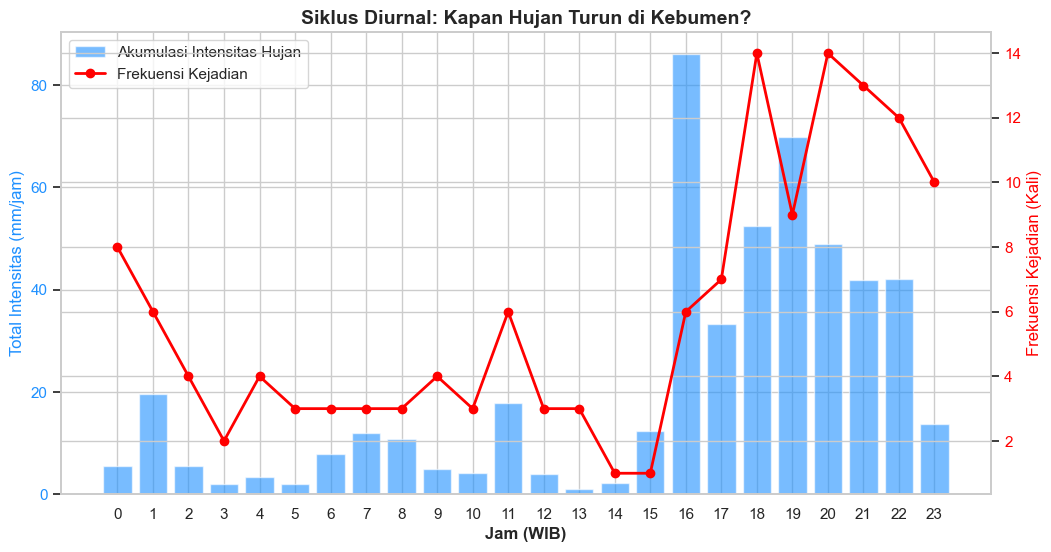

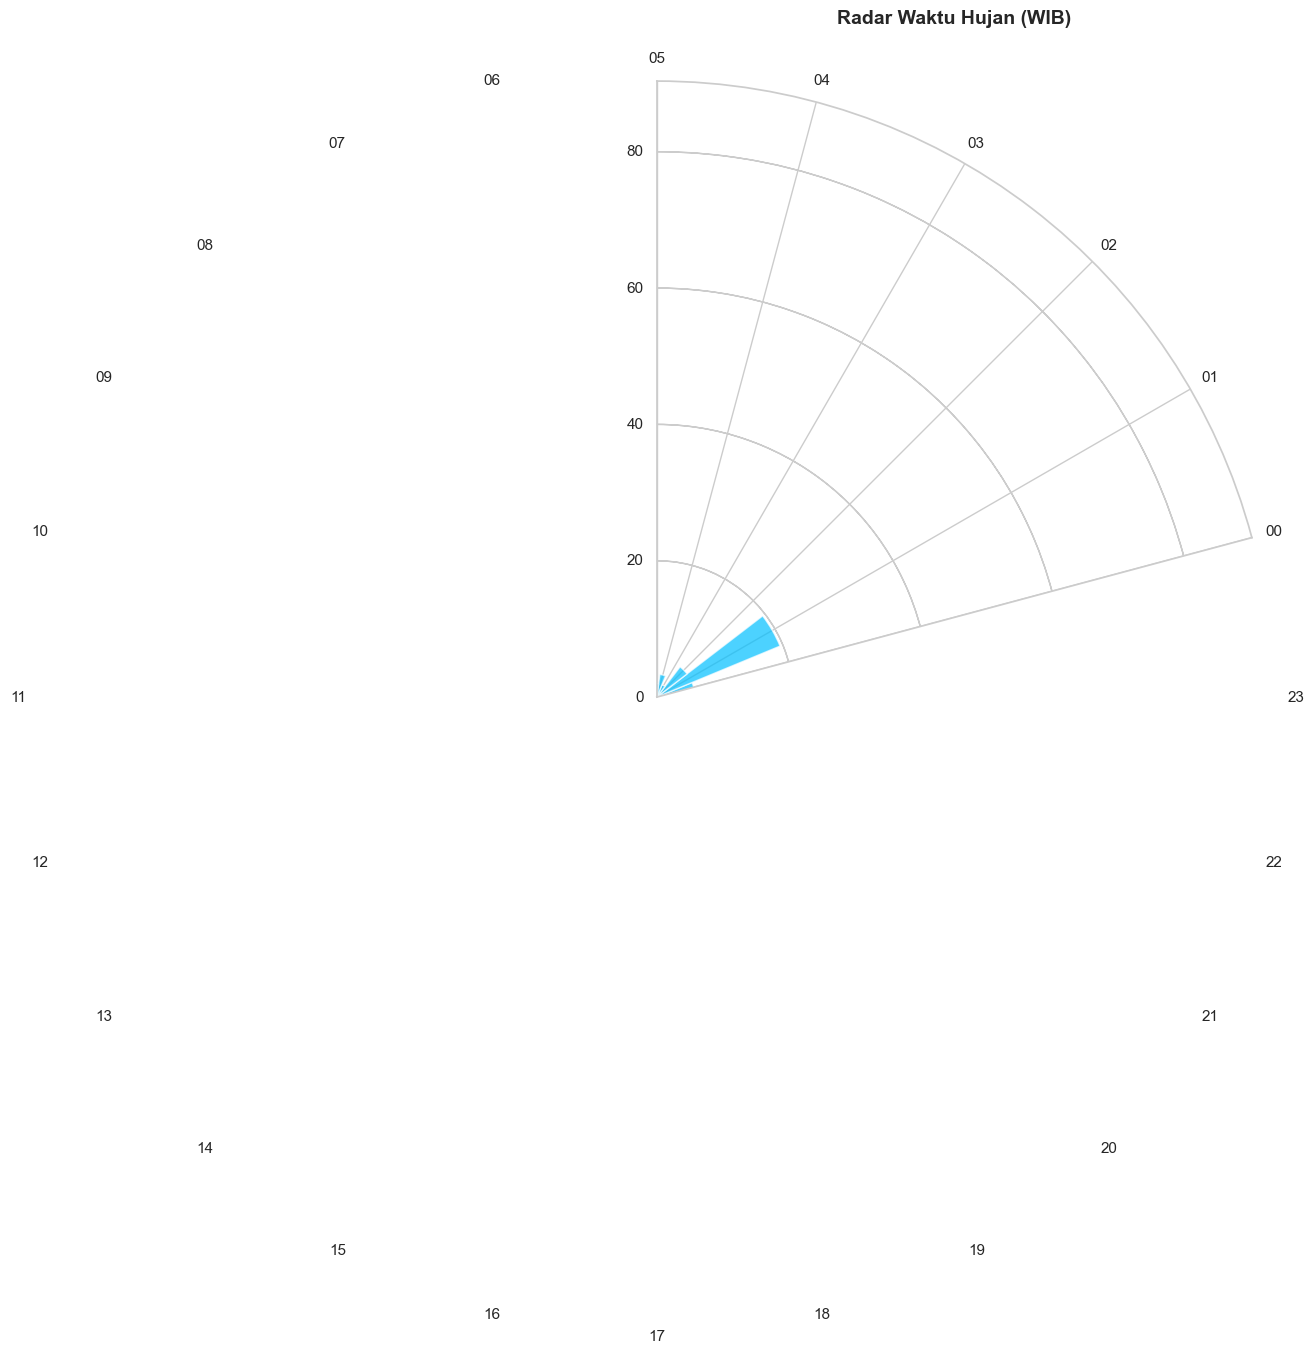

In [143]:
# --- 1. PERSIAPAN DATA ---
# Kita copy dataframe Anda agar data asli aman
df_analisis = data_meteorologi.copy()

# [PENTING] Kembalikan ke WIB (Asia/Jakarta) untuk analisis jam
# Karena pola aktivitas manusia dan matahari mengikuti waktu lokal
df_analisis = df_analisis.tz_convert('Asia/Jakarta')

# Ekstrak jam (0-23) dari index
df_analisis['jam'] = df_analisis.index.hour

# --- 2. HITUNG STATISTIK PER JAM ---

# A. Total Intensitas (Akumulasi 'laju_hujan')
# Menjawab: "Di jam berapa hujan biasanya paling deras?"
# Karena 'laju_hujan' Anda adalah nilai MAX per jam, menjumlahkannya 
# akan menunjukkan jam mana yang sering mendapat intensitas tinggi.
hourly_intensity = df_analisis.groupby('jam')['laju_hujan'].sum()

# B. Frekuensi Kejadian (Peluang)
# Menjawab: "Di jam berapa paling sering terjadi hujan?"
# Kita filter jam dimana laju_hujan > 0.2 (bukan noise)
jam_basah = df_analisis[df_analisis['laju_hujan'] > 0.2]
hourly_freq = jam_basah.groupby('jam')['laju_hujan'].count()

# Gabungkan data (isi 0 jika tidak ada hujan)
df_stats = pd.DataFrame({
    'Total Intensitas': hourly_intensity,
    'Frekuensi': hourly_freq
}).fillna(0)

print("--- Statistik Diurnal (WIB) ---")
print(df_stats.head())

# --- 3. VISUALISASI 1: GRAFIK KOMBO (Bar & Line) ---

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Batang (Intensitas)
ax1.bar(df_stats.index, df_stats['Total Intensitas'], color='dodgerblue', alpha=0.6, label='Akumulasi Intensitas Hujan')
ax1.set_xlabel('Jam (WIB)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Intensitas (mm/jam)', color='dodgerblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='dodgerblue')
ax1.set_xticks(range(0, 24)) 

# Plot Garis (Frekuensi)
ax2 = ax1.twinx()
ax2.plot(df_stats.index, df_stats['Frekuensi'], color='red', marker='o', linewidth=2, label='Frekuensi Kejadian')
ax2.set_ylabel('Frekuensi Kejadian (Kali)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Siklus Diurnal: Kapan Hujan Turun di Kebumen?', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Gabung Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

# --- 4. VISUALISASI 2: POLAR PLOT (Jam Dinding) ---

# Setup sudut lingkaran (Jam 0-23)
theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)
# Geser agar jam 00:00 ada di Atas (Utara), bukan Kanan
theta = theta + np.pi/2 
# Putar arah jarum jam (bukan matematis berlawanan arah)
theta = theta[::-1] 
width = (2*np.pi) / 24

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')

# Plot Data
bars = ax.bar(theta, df_stats['Total Intensitas'], width=width, bottom=0.0, 
              color='deepskyblue', alpha=0.7, edgecolor='white')

# Label Jam
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(theta)
ax.set_xticklabels([f"{h:02d}" for h in range(24)])

plt.title("Radar Waktu Hujan (WIB)", fontsize=14, fontweight='bold', pad=20)
plt.show()

In [144]:
data_klimat.describe()

curah_hujan  rata_suhu  suhu_maks  suhu_mini
count    29.000000  29.000000  29.000000  29.000000
mean     17.370972  27.652090  31.943033  25.180499
std      20.600769   0.945451   1.942115   0.639323
min       0.000000  25.448301  25.813029  24.152705
25%       1.676400  27.284960  30.872943  24.922116
50%      13.411200  27.822171  32.501309  25.158678
75%      26.263600  28.190197  32.961318  25.437756
max      93.040200  30.161868  35.128024  27.582386

In [145]:
data_meteorologi.describe()

laju_hujan   rata_suhu   suhu_maks   suhu_mini    storm_id
count  661.000000  661.000000  661.000000  661.000000  661.000000
mean     0.762115   27.640423   28.078263   27.207457   57.111952
std      3.331300    2.491301    2.761362    2.271230   34.919165
min      0.000000   24.152705   24.449910   23.750290    1.000000
25%      0.000000   25.596193   25.755710   25.400550   27.000000
50%      0.000000   26.831668   27.141600   26.511410   59.000000
75%      0.000000   29.350500   30.073625   28.823910   91.000000
max     58.674000   35.128024   38.260860   33.982990  109.000000

In [146]:
data_meteorologi['laju_hujan'].sum()

np.float64(503.7582)

In [147]:
data_klimat['curah_hujan'].sum()

np.float64(503.75819999999993)